# STAGE 1 : Hyperparameter Search / Sweep / Candidate Selection


In [3]:
from pathlib import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Folder to save sweep results
SWEEP_SAVE_DIR = Path("/content/drive/MyDrive/vit_cifar10_sweep_results")
SWEEP_SAVE_DIR.mkdir(parents=True, exist_ok=True)
print("Sweep results will be saved in:", SWEEP_SAVE_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sweep results will be saved in: /content/drive/MyDrive/vit_cifar10_sweep_results


In [4]:
# Colab cell 0: install wandb only (torch is preinstalled in Colab)
!pip install -q wandb


# Importing requirements

In [5]:
import os, time, random, json
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit

# mixed precision
from torch.cuda.amp import autocast, GradScaler

# wandb
import wandb

# Seed for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# Data Loading + Building Model

In [6]:

# Helper: pick a valid num_heads that divides embed_dim (closest to requested)
def pick_num_heads(embed_dim:int, requested_heads:int) -> int:
    # compute divisors
    divs = [d for d in range(1, embed_dim+1) if embed_dim % d == 0]
    # choose divisor closest to requested_heads (prefer <= requested if tie)
    best = min(divs, key=lambda d: (abs(d - requested_heads), -d))
    return best

class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=384, stride=None):
        super().__init__()
        stride = patch_size if stride is None else stride
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride)
        self.num_patches = (img_size // stride) * (img_size // stride)

    def forward(self, x):
        x = self.proj(x)            # B, C, H', W'
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1,2)  # B, N, C
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    def forward(self,x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x)
        return x

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        rand = keep + torch.rand(shape, device=x.device, dtype=x.dtype)
        rand.floor_()
        return x.div(keep) * rand

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.0, attn_drop=0.0, drop_path=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        # MultiheadAttention expects embed_dim divisible by num_heads
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True, dropout=attn_drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim*mlp_ratio), drop=drop)
    def forward(self, x):
        x_res = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x,x,x, need_weights=False)
        x = x_res + self.drop_path(attn_out)
        x_res = x
        x = self.norm2(x)
        x = x_res + self.drop_path(self.mlp(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self,
                 img_size=32, patch_size=4, stride=None, in_chans=3, num_classes=10,
                 embed_dim=256, depth=8, num_heads=4, mlp_ratio=4.0,
                 drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0):
        super().__init__()
        # ensure num_heads divides embed_dim
        if embed_dim % num_heads != 0:
            chosen = pick_num_heads(embed_dim, num_heads)
            print(f"[Info] Adjusting num_heads {num_heads} -> {chosen} to divide embed_dim {embed_dim}")
            num_heads = chosen

        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim, stride=stride)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))
        self.pos_drop = nn.Dropout(drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i])
            for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self,m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls_out = x[:,0]
        out = self.head(cls_out)
        return out


In [10]:
from torchvision.transforms import RandAugment

def build_transforms(train=True, use_randaugment=True):
    if train:
        aug = []
        if use_randaugment:
            aug.append(RandAugment(num_ops=2, magnitude=9))
        aug += [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
        ]
        return transforms.Compose(aug)
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
        ])

def get_dataloaders(batch_size=128, num_workers=2, use_randaugment=True, subset_ratio:Optional[float]=None):
    full_transform_train = build_transforms(train=True, use_randaugment=use_randaugment)
    test_transform = build_transforms(train=False, use_randaugment=False)

    # Full dataset
    full_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=full_transform_train)
    targets = np.array(full_dataset.targets)

    # Stratified split 90% train / 10% val
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    train_idx_full, val_idx = next(sss.split(np.zeros(len(targets)), targets))

    # Proxy subset for Stage 1
    if subset_ratio is not None and 0 < subset_ratio < 1.0:
        targets_train_full = targets[train_idx_full]
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=1.0-subset_ratio, random_state=42)
        sub_idx_rel, _ = next(sss2.split(np.zeros(len(targets_train_full)), targets_train_full))
        train_idx = train_idx_full[sub_idx_rel]
    else:
        train_idx = train_idx_full

    train_dataset = Subset(full_dataset, train_idx)
    val_dataset_full = datasets.CIFAR10(root="./data", train=True, download=False, transform=test_transform)
    val_dataset = Subset(val_dataset_full, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
    return train_loader, val_loader


In [11]:

def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, None, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    idx = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_one_epoch(model, loader, optimizer, criterion, scaler, device, epoch, config):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()

        if config.get("mixup_alpha", 0.0) > 0:
            images, targets_a, targets_b, lam = mixup_data(images, targets, alpha=config["mixup_alpha"])
        else:
            lam = None

        with autocast():
            outputs = model(images)
            if lam is not None:
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        if config.get("grad_clip", 0.0) > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        if lam is not None:
            correct += (lam * preds.eq(targets_a).sum().item() + (1 - lam) * preds.eq(targets_b).sum().item())
        else:
            correct += preds.eq(targets).sum().item()
        total += images.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += images.size(0)
    return running_loss/total, correct/total


# Early stopping + ModelCheckpoint

In [12]:

class EarlyStopping:
    def __init__(self, patience=8, mode="max", min_delta=1e-4):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = -float("inf") if mode=="max" else float("inf")
        self.num_bad = 0
    def step(self, metric):
        improved = (metric > self.best + self.min_delta) if self.mode=="max" else (metric < self.best - self.min_delta)
        if improved:
            self.best = metric
            self.num_bad = 0
            return False
        else:
            self.num_bad += 1
            return self.num_bad >= self.patience

class ModelCheckpoint:
    def __init__(self, path="best.pth"):
        self.path = path
        self.best = -float("inf")
    def step(self, metric, model, optimizer=None, epoch=None):
        if metric > self.best:
            self.best = metric
            state = {"model_state": model.state_dict(), "optim_state": optimizer.state_dict() if optimizer else None, "epoch": epoch}
            torch.save(state, self.path)
            return True
        return False

from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, StepLR, SequentialLR
def get_scheduler(optimizer, name, epochs, warmup_epochs=5, step_size=30):
    if name == "cosine":
        if warmup_epochs > 0:
            def warmup_lambda(ep): return float(ep+1)/float(max(1,warmup_epochs))
            warm = LambdaLR(optimizer, lr_lambda=warmup_lambda)
            cosine = CosineAnnealingLR(optimizer, T_max=max(1, epochs - warmup_epochs))
            scheduler = SequentialLR(optimizer, schedulers=[warm, cosine], milestones=[warmup_epochs])
        else:
            scheduler = CosineAnnealingLR(optimizer, T_max=max(1, epochs))
    elif name == "step":
        scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)
    else:
        scheduler = None
    return scheduler


# Train Function

In [13]:
import json

def run_train_save(config=None, save_dir=SWEEP_SAVE_DIR):
    default = {
        "epochs": 20, "batch_size": 128, "img_size":32, "patch_size":4, "stride":None,
        "embed_dim": 128, "depth":4, "num_heads":2, "mlp_ratio":4.0,
        "drop_rate":0.0, "drop_path_rate":0.1, "lr":1e-3, "weight_decay":0.05,
        "optimizer":"adamw", "momentum":0.9, "scheduler":"cosine", "warmup_epochs":5,
        "step_size":30, "mixup_alpha":0.0, "use_randaugment":True, "grad_clip":0.0,
        "patience":6, "num_workers":2, "subset_ratio":0.2
    }
    if config is None:
        config = default
    else:
        for k,v in default.items():
            config.setdefault(k,v)

    # Start W&B run
    run = wandb.init(config=config, reinit=True)
    cfg = wandb.config

    train_loader, val_loader = get_dataloaders(batch_size=cfg.batch_size, num_workers=cfg.num_workers, use_randaugment=cfg.use_randaugment, subset_ratio=cfg.subset_ratio)

    model = VisionTransformer(img_size=cfg.img_size, patch_size=cfg.patch_size, stride=cfg.stride,
                              num_classes=10, embed_dim=cfg.embed_dim, depth=cfg.depth, num_heads=cfg.num_heads,
                              mlp_ratio=cfg.mlp_ratio, drop_rate=cfg.drop_rate, drop_path_rate=cfg.drop_path_rate).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay) if cfg.optimizer=="adamw" else torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
    scheduler = get_scheduler(optimizer, cfg.scheduler, cfg.epochs, warmup_epochs=cfg.warmup_epochs, step_size=cfg.step_size)

    scaler = GradScaler()
    early_stopper = EarlyStopping(patience=cfg.patience, mode="max")
    ckpt = ModelCheckpoint(path="best_model.pth")

    best_val_acc = 0.0
    for epoch in range(cfg.epochs):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device, epoch, cfg)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        if scheduler is not None:
            try: scheduler.step()
            except: pass

        if ckpt.step(val_acc, model, optimizer, epoch): best_val_acc = val_acc

        wandb.log({"epoch":epoch, "train_loss":train_loss, "train_acc":train_acc, "val_loss":val_loss, "val_acc":val_acc})

        print(f"[{epoch+1}/{cfg.epochs}] train_acc={train_acc:.4f} val_acc={val_acc:.4f} time={time.time()-t0:.1f}s")

        if early_stopper.step(val_acc):
            print("Early stopping triggered")
            break

    # Save best model locally
    if os.path.exists("best_model.pth"):
        torch.save({"config": dict(cfg), "best_val_acc": best_val_acc}, save_dir/f"{wandb.run.id}.json")
        print("Saved run results to Drive:", save_dir/f"{wandb.run.id}.json")

    wandb.summary["best_val_acc"] = best_val_acc
    wandb.finish()
    return best_val_acc


# wandb Sweep Configurationn

In [15]:
sweep_config_stage1 = {
    "method": "bayes",
    "metric": {"name": "val_acc", "goal": "maximize"},
    "parameters": {
        "patch_size": {"values": [2,4]},
        "embed_dim": {"values": [128,192]},
        "depth": {"values": [4,6]},
        "num_heads": {"values": [2,4]},
        "lr": {"min":1e-5, "max":1e-3},
        "optimizer": {"values": ["adamw","sgd"]},
        "scheduler": {"values":["cosine","step"]},
        "batch_size": {"values":[64,128]},
        "mixup_alpha": {"values":[0.0,0.1]},
        "epochs":{"value":20},
        "patience":{"value":6},
        "subset_ratio":{"value":0.2}  # proxy dataset
    }
}

sweep_id_stage1 = wandb.sweep(sweep_config_stage1, project="vit-cifar10-first")
print("Stage1 sweep id:", sweep_id_stage1)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: cb2jts3a
Sweep URL: https://wandb.ai/kotasathvik7/vit-cifar10-first/sweeps/cb2jts3a
Stage1 sweep id: cb2jts3a


# Sweep Initialization and calling the Trainer function

In [20]:

from pathlib import Path
from google.colab import drive
import time, json, os
import wandb

# 1) Ensure Drive mounted and save dir exists
drive.mount('/content/drive', force_remount=False)
SWEEP_SAVE_DIR = Path("/content/drive/MyDrive/vit_cifar10_sweep_results")
SWEEP_SAVE_DIR.mkdir(parents=True, exist_ok=True)
print("Sweep results dir:", SWEEP_SAVE_DIR)

# 2) sanity checks
if 'sweep_id_stage1' not in globals():
    raise RuntimeError("sweep_id_stage1 not found. Run the cell that creates the sweep first (Step 7).")

# 3) Agent wrapper function (no args) — wandb.agent will call this
def agent_fn():
    # wandb has already initialised run context for the agent; get the config
    try:
        cfg = dict(wandb.config)  # copy config from wandb agent
    except Exception:
        cfg = None

    # If you have run_train_save (from earlier Step 5), prefer that.
    # If its name differs, replace run_train_save with your trainer function that accepts a config dict.
    try:
        # call your training function which should create its own wandb.init if needed,
        # or rely on wandb.agent to have set wandb.run / wandb.config.
        final_acc = run_train_save(cfg)   # <- ensure run_train_save exists in session
    except NameError:
        # fallback to run_train if that's the function you used previously
        final_acc = run_train(cfg)

    # save a small JSON in Drive with the config + final metric (unique filename)
    safe_cfg = cfg if isinstance(cfg, dict) else {}
    run_id = wandb.run.id if wandb.run else f"local_{int(time.time())}"
    filename = f"{safe_cfg.get('patch_size','p')}_{safe_cfg.get('embed_dim','e')}_{run_id}.json"
    filepath = SWEEP_SAVE_DIR / filename
    out = {"config": safe_cfg, "final_val_acc": float(final_acc) if final_acc is not None else None, "wandb_run_id": run_id, "timestamp": time.time()}
    with open(filepath, "w") as f:
        json.dump(out, f, indent=2)
    print(f"Saved run result to {filepath}")

wandb.agent(sweep_id_stage1, function=agent_fn, count=20)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sweep results dir: /content/drive/MyDrive/vit_cifar10_sweep_results


wandb: Agent Starting Run: 8rlxrifr with config:
wandb: 	batch_size: 128
wandb: 	depth: 6
wandb: 	embed_dim: 192
wandb: 	epochs: 20
wandb: 	lr: 0.0003770669483763933
wandb: 	mixup_alpha: 0.1
wandb: 	num_heads: 2
wandb: 	optimizer: sgd
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2
wandb: Currently logged in as: kotasathvik25 (kotasathvik7) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1238 val_acc=0.1800 time=13.0s
[2/20] train_acc=0.1707 val_acc=0.2162 time=13.1s
[3/20] train_acc=0.1890 val_acc=0.2268 time=10.6s
[4/20] train_acc=0.1976 val_acc=0.2382 time=11.5s
[5/20] train_acc=0.2049 val_acc=0.2264 time=11.6s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.2164 val_acc=0.2572 time=11.4s
[7/20] train_acc=0.2331 val_acc=0.2580 time=11.5s
[8/20] train_acc=0.2309 val_acc=0.2808 time=11.0s
[9/20] train_acc=0.2435 val_acc=0.2852 time=12.0s
[10/20] train_acc=0.2472 val_acc=0.2856 time=11.9s
[11/20] train_acc=0.2487 val_acc=0.2846 time=11.8s
[12/20] train_acc=0.2572 val_acc=0.2972 time=11.4s
[13/20] train_acc=0.2644 val_acc=0.3046 time=11.4s
[14/20] train_acc=0.2700 val_acc=0.3024 time=11.8s
[15/20] train_acc=0.2674 val_acc=0.3008 time=11.8s
[16/20] train_acc=0.2707 val_acc=0.2996 time=11.6s
[17/20] train_acc=0.2783 val_acc=0.3038 time=12.5s
[18/20] train_acc=0.2717 val_acc=0.3072 time=11.7s
[19/20] train_acc=0.2687 val_acc=0.3118 time=11.8s
[20/20] train_acc=0.2759 val_acc=0.3114 time=11.7s
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/8rlxrifr.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759560093.json


wandb: Agent Starting Run: lrzrp41t with config:
wandb: 	batch_size: 64
wandb: 	depth: 6
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.000654617253719141
wandb: 	mixup_alpha: 0.1
wandb: 	num_heads: 4
wandb: 	optimizer: adamw
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: step
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1888 val_acc=0.2228 time=11.7s
[2/20] train_acc=0.2264 val_acc=0.2824 time=11.7s
[3/20] train_acc=0.2573 val_acc=0.3196 time=11.0s
[4/20] train_acc=0.2727 val_acc=0.3468 time=10.5s
[5/20] train_acc=0.2925 val_acc=0.3444 time=11.6s
[6/20] train_acc=0.3094 val_acc=0.3776 time=11.7s
[7/20] train_acc=0.3273 val_acc=0.3844 time=11.7s
[8/20] train_acc=0.3587 val_acc=0.4378 time=10.6s
[9/20] train_acc=0.3604 val_acc=0.4508 time=11.4s
[10/20] train_acc=0.3751 val_acc=0.4430 time=12.1s
[11/20] train_acc=0.3982 val_acc=0.5010 time=13.7s
[12/20] train_acc=0.4108 val_acc=0.4958 time=11.7s
[13/20] train_acc=0.4223 val_acc=0.4868 time=10.6s
[14/20] train_acc=0.4374 val_acc=0.5270 time=11.5s
[15/20] train_acc=0.4470 val_acc=0.5266 time=11.6s
[16/20] train_acc=0.4517 val_acc=0.5306 time=11.5s
[17/20] train_acc=0.4548 val_acc=0.5458 time=10.5s
[18/20] train_acc=0.4586 val_acc=0.5564 time=10.8s
[19/20] train_acc=0.4757 val_acc=0.5528 time=11.5s
[20/20] train_acc=0.4696 val_acc=0.5504 

Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759560328.json


wandb: Agent Starting Run: v4emohks with config:
wandb: 	batch_size: 128
wandb: 	depth: 4
wandb: 	embed_dim: 192
wandb: 	epochs: 20
wandb: 	lr: 0.0003052448857210025
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 2
wandb: 	optimizer: sgd
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: step
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1571 val_acc=0.2248 time=9.0s
[2/20] train_acc=0.2062 val_acc=0.2402 time=9.6s
[3/20] train_acc=0.2172 val_acc=0.2446 time=10.2s
[4/20] train_acc=0.2332 val_acc=0.2530 time=8.3s
[5/20] train_acc=0.2418 val_acc=0.2566 time=10.9s
[6/20] train_acc=0.2481 val_acc=0.2700 time=11.0s
[7/20] train_acc=0.2531 val_acc=0.2838 time=8.6s
[8/20] train_acc=0.2598 val_acc=0.2866 time=10.2s
[9/20] train_acc=0.2617 val_acc=0.2818 time=10.0s
[10/20] train_acc=0.2712 val_acc=0.3006 time=8.6s
[11/20] train_acc=0.2693 val_acc=0.3020 time=10.3s
[12/20] train_acc=0.2797 val_acc=0.2894 time=10.1s
[13/20] train_acc=0.2748 val_acc=0.2872 time=8.6s
[14/20] train_acc=0.2743 val_acc=0.3068 time=10.2s
[15/20] train_acc=0.2773 val_acc=0.3128 time=9.8s
[16/20] train_acc=0.2830 val_acc=0.3172 time=8.8s
[17/20] train_acc=0.2911 val_acc=0.3104 time=10.2s
[18/20] train_acc=0.2934 val_acc=0.3280 time=9.8s
[19/20] train_acc=0.2904 val_acc=0.3236 time=9.1s
[20/20] train_acc=0.2943 val_acc=0.3286 time=10.1s

Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759560535.json


wandb: Agent Starting Run: s6gy1dn2 with config:
wandb: 	batch_size: 64
wandb: 	depth: 6
wandb: 	embed_dim: 192
wandb: 	epochs: 20
wandb: 	lr: 0.00039235858765029766
wandb: 	mixup_alpha: 0.1
wandb: 	num_heads: 4
wandb: 	optimizer: sgd
wandb: 	patch_size: 4
wandb: 	patience: 6
wandb: 	scheduler: step
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1942 val_acc=0.2396 time=10.7s
[2/20] train_acc=0.2187 val_acc=0.2638 time=13.0s
[3/20] train_acc=0.2403 val_acc=0.2704 time=11.1s
[4/20] train_acc=0.2527 val_acc=0.2986 time=9.5s
[5/20] train_acc=0.2555 val_acc=0.2902 time=10.8s
[6/20] train_acc=0.2596 val_acc=0.3138 time=11.1s
[7/20] train_acc=0.2628 val_acc=0.2904 time=10.5s
[8/20] train_acc=0.2748 val_acc=0.3102 time=9.5s
[9/20] train_acc=0.2824 val_acc=0.3034 time=11.1s
[10/20] train_acc=0.2840 val_acc=0.3122 time=10.9s
[11/20] train_acc=0.2797 val_acc=0.3130 time=9.8s
[12/20] train_acc=0.2816 val_acc=0.3312 time=10.5s
[13/20] train_acc=0.2918 val_acc=0.3126 time=11.0s
[14/20] train_acc=0.2908 val_acc=0.3070 time=11.1s
[15/20] train_acc=0.2873 val_acc=0.3222 time=9.3s
[16/20] train_acc=0.2999 val_acc=0.3296 time=10.8s
[17/20] train_acc=0.2928 val_acc=0.3422 time=10.8s
[18/20] train_acc=0.2919 val_acc=0.3132 time=12.6s
[19/20] train_acc=0.2938 val_acc=0.3422 time=9.1s
[20/20] train_acc=0.3006 val_acc=0.3290 time=

Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759560756.json


wandb: Agent Starting Run: aecphydh with config:
wandb: 	batch_size: 64
wandb: 	depth: 4
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.0006496504019077107
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 4
wandb: 	optimizer: adamw
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.2120 val_acc=0.2704 time=9.1s
[2/20] train_acc=0.2454 val_acc=0.2860 time=10.4s
[3/20] train_acc=0.2718 val_acc=0.3064 time=10.1s
[4/20] train_acc=0.2954 val_acc=0.3578 time=9.0s
[5/20] train_acc=0.3112 val_acc=0.3974 time=10.3s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.3424 val_acc=0.3980 time=9.8s
[7/20] train_acc=0.3653 val_acc=0.4144 time=9.2s
[8/20] train_acc=0.3908 val_acc=0.4460 time=10.3s
[9/20] train_acc=0.4118 val_acc=0.4918 time=9.8s
[10/20] train_acc=0.4326 val_acc=0.4842 time=8.9s
[11/20] train_acc=0.4451 val_acc=0.5022 time=10.4s
[12/20] train_acc=0.4627 val_acc=0.4956 time=9.9s
[13/20] train_acc=0.4799 val_acc=0.5414 time=9.2s
[14/20] train_acc=0.4957 val_acc=0.5434 time=11.2s
[15/20] train_acc=0.5104 val_acc=0.5754 time=11.2s
[16/20] train_acc=0.5161 val_acc=0.5844 time=8.6s
[17/20] train_acc=0.5360 val_acc=0.5730 time=10.4s
[18/20] train_acc=0.5444 val_acc=0.5910 time=10.4s
[19/20] train_acc=0.5503 val_acc=0.5856 time=9.0s
[20/20] train_acc=0.5527 val_acc=0.5902 time=10.4s
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/aecphydh.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759560961.json


wandb: Agent Starting Run: etdqjog6 with config:
wandb: 	batch_size: 64
wandb: 	depth: 4
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.0004354853274656345
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 4
wandb: 	optimizer: sgd
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: step
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1746 val_acc=0.2244 time=10.6s
[2/20] train_acc=0.2157 val_acc=0.2484 time=8.7s
[3/20] train_acc=0.2328 val_acc=0.2686 time=10.6s
[4/20] train_acc=0.2457 val_acc=0.2446 time=10.5s
[5/20] train_acc=0.2520 val_acc=0.2610 time=8.8s
[6/20] train_acc=0.2553 val_acc=0.2668 time=10.3s
[7/20] train_acc=0.2652 val_acc=0.2660 time=10.3s
[8/20] train_acc=0.2630 val_acc=0.2954 time=8.5s
[9/20] train_acc=0.2709 val_acc=0.3014 time=10.3s
[10/20] train_acc=0.2792 val_acc=0.2854 time=10.4s
[11/20] train_acc=0.2747 val_acc=0.3048 time=11.5s
[12/20] train_acc=0.2797 val_acc=0.2886 time=9.3s
[13/20] train_acc=0.2778 val_acc=0.2982 time=10.5s
[14/20] train_acc=0.2850 val_acc=0.3050 time=10.1s
[15/20] train_acc=0.2789 val_acc=0.2956 time=9.1s
[16/20] train_acc=0.2780 val_acc=0.2848 time=10.6s
[17/20] train_acc=0.2779 val_acc=0.2750 time=10.1s
[18/20] train_acc=0.2826 val_acc=0.2766 time=9.0s
[19/20] train_acc=0.2808 val_acc=0.3176 time=10.5s
[20/20] train_acc=0.2740 val_acc=0.3100 time=1

Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759561172.json


wandb: Agent Starting Run: uzx7f4wj with config:
wandb: 	batch_size: 128
wandb: 	depth: 4
wandb: 	embed_dim: 192
wandb: 	epochs: 20
wandb: 	lr: 0.0007006570486728209
wandb: 	mixup_alpha: 0.1
wandb: 	num_heads: 2
wandb: 	optimizer: sgd
wandb: 	patch_size: 4
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1421 val_acc=0.1988 time=9.5s
[2/20] train_acc=0.1870 val_acc=0.2380 time=7.6s
[3/20] train_acc=0.2033 val_acc=0.2320 time=9.0s
[4/20] train_acc=0.2181 val_acc=0.2572 time=8.7s
[5/20] train_acc=0.2385 val_acc=0.2818 time=7.7s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.2480 val_acc=0.2828 time=9.2s
[7/20] train_acc=0.2586 val_acc=0.2856 time=7.5s
[8/20] train_acc=0.2595 val_acc=0.2954 time=11.0s
[9/20] train_acc=0.2556 val_acc=0.3164 time=8.4s
[10/20] train_acc=0.2652 val_acc=0.3138 time=8.1s
[11/20] train_acc=0.2677 val_acc=0.3096 time=9.0s
[12/20] train_acc=0.2779 val_acc=0.3180 time=7.6s
[13/20] train_acc=0.2796 val_acc=0.3266 time=9.1s
[14/20] train_acc=0.2873 val_acc=0.3382 time=7.4s
[15/20] train_acc=0.2712 val_acc=0.3222 time=9.2s
[16/20] train_acc=0.2846 val_acc=0.3264 time=8.1s
[17/20] train_acc=0.2924 val_acc=0.3262 time=8.4s
[18/20] train_acc=0.2798 val_acc=0.3362 time=8.9s
[19/20] train_acc=0.2852 val_acc=0.3346 time=7.5s
[20/20] train_acc=0.2867 val_acc=0.3348 time=9.1s
Early stopping triggered
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/uzx7f4wj.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759561352.json


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e0fdukhr with config:
wandb: 	batch_size: 128
wandb: 	depth: 6
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.00025171523109588013
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 4
wandb: 	optimizer: adamw
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1950 val_acc=0.2372 time=10.1s
[2/20] train_acc=0.2400 val_acc=0.2718 time=8.7s
[3/20] train_acc=0.2548 val_acc=0.3166 time=10.0s
[4/20] train_acc=0.2806 val_acc=0.3348 time=10.3s
[5/20] train_acc=0.3120 val_acc=0.3542 time=9.1s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.3229 val_acc=0.3582 time=11.9s
[7/20] train_acc=0.3492 val_acc=0.3854 time=10.2s
[8/20] train_acc=0.3793 val_acc=0.4434 time=8.5s
[9/20] train_acc=0.4040 val_acc=0.4636 time=10.4s
[10/20] train_acc=0.4192 val_acc=0.4708 time=10.2s
[11/20] train_acc=0.4371 val_acc=0.4824 time=8.6s
[12/20] train_acc=0.4426 val_acc=0.5020 time=10.4s
[13/20] train_acc=0.4668 val_acc=0.5170 time=10.2s
[14/20] train_acc=0.4870 val_acc=0.5296 time=9.0s
[15/20] train_acc=0.4939 val_acc=0.5334 time=10.0s
[16/20] train_acc=0.4966 val_acc=0.5452 time=10.3s
[17/20] train_acc=0.5117 val_acc=0.5550 time=8.8s
[18/20] train_acc=0.5118 val_acc=0.5498 time=10.2s
[19/20] train_acc=0.5201 val_acc=0.5580 time=10.2s
[20/20] train_acc=0.5239 val_acc=0.5604 time=8.6s
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/e0fdukhr.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759561564.json


wandb: Agent Starting Run: pm58eea3 with config:
wandb: 	batch_size: 128
wandb: 	depth: 4
wandb: 	embed_dim: 192
wandb: 	epochs: 20
wandb: 	lr: 0.0009992722603646325
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 2
wandb: 	optimizer: sgd
wandb: 	patch_size: 4
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1716 val_acc=0.2264 time=9.3s
[2/20] train_acc=0.2089 val_acc=0.2416 time=7.4s
[3/20] train_acc=0.2363 val_acc=0.2592 time=11.0s
[4/20] train_acc=0.2538 val_acc=0.2850 time=7.4s
[5/20] train_acc=0.2654 val_acc=0.2948 time=9.2s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.2733 val_acc=0.2780 time=7.3s
[7/20] train_acc=0.2800 val_acc=0.3028 time=9.0s
[8/20] train_acc=0.2879 val_acc=0.3066 time=8.2s
[9/20] train_acc=0.2871 val_acc=0.3208 time=8.1s
[10/20] train_acc=0.2924 val_acc=0.3180 time=9.0s
[11/20] train_acc=0.2990 val_acc=0.3046 time=7.3s
[12/20] train_acc=0.3070 val_acc=0.3122 time=9.1s
[13/20] train_acc=0.3082 val_acc=0.3490 time=7.3s
[14/20] train_acc=0.3074 val_acc=0.3334 time=8.9s
[15/20] train_acc=0.3126 val_acc=0.3582 time=7.6s
[16/20] train_acc=0.3209 val_acc=0.3512 time=8.9s
[17/20] train_acc=0.3282 val_acc=0.3560 time=8.6s
[18/20] train_acc=0.3246 val_acc=0.3578 time=7.5s
[19/20] train_acc=0.3267 val_acc=0.3574 time=8.9s
[20/20] train_acc=0.3271 val_acc=0.3566 time=7.4s
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/pm58eea3.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759561740.json


wandb: Agent Starting Run: 85i9gsma with config:
wandb: 	batch_size: 128
wandb: 	depth: 4
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.0005072350673505519
wandb: 	mixup_alpha: 0.1
wandb: 	num_heads: 2
wandb: 	optimizer: sgd
wandb: 	patch_size: 4
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1533 val_acc=0.1936 time=9.2s
[2/20] train_acc=0.1879 val_acc=0.2194 time=7.6s
[3/20] train_acc=0.2046 val_acc=0.2374 time=11.1s
[4/20] train_acc=0.2061 val_acc=0.2474 time=7.3s
[5/20] train_acc=0.2208 val_acc=0.2492 time=9.0s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.2356 val_acc=0.2628 time=7.3s
[7/20] train_acc=0.2394 val_acc=0.2710 time=9.1s
[8/20] train_acc=0.2568 val_acc=0.2784 time=8.2s
[9/20] train_acc=0.2594 val_acc=0.2938 time=8.2s
[10/20] train_acc=0.2556 val_acc=0.2882 time=9.0s
[11/20] train_acc=0.2668 val_acc=0.3042 time=7.3s
[12/20] train_acc=0.2724 val_acc=0.3060 time=9.0s
[13/20] train_acc=0.2698 val_acc=0.3122 time=7.2s
[14/20] train_acc=0.2774 val_acc=0.3192 time=8.9s
[15/20] train_acc=0.2749 val_acc=0.3208 time=7.5s
[16/20] train_acc=0.2876 val_acc=0.3142 time=8.5s
[17/20] train_acc=0.2873 val_acc=0.3276 time=8.5s
[18/20] train_acc=0.2862 val_acc=0.3248 time=7.5s
[19/20] train_acc=0.2948 val_acc=0.3246 time=9.0s
[20/20] train_acc=0.2882 val_acc=0.3244 time=7.2s
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/85i9gsma.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759561917.json


wandb: Agent Starting Run: sb8655ye with config:
wandb: 	batch_size: 64
wandb: 	depth: 4
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.0005984469228782903
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 4
wandb: 	optimizer: sgd
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: step
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1842 val_acc=0.2396 time=10.2s
[2/20] train_acc=0.2110 val_acc=0.2600 time=10.6s
[3/20] train_acc=0.2406 val_acc=0.2700 time=9.9s
[4/20] train_acc=0.2551 val_acc=0.2824 time=10.2s
[5/20] train_acc=0.2657 val_acc=0.2884 time=9.3s
[6/20] train_acc=0.2579 val_acc=0.2820 time=10.3s
[7/20] train_acc=0.2692 val_acc=0.2934 time=10.3s
[8/20] train_acc=0.2627 val_acc=0.2864 time=9.2s
[9/20] train_acc=0.2759 val_acc=0.3150 time=9.9s
[10/20] train_acc=0.2769 val_acc=0.2882 time=10.2s
[11/20] train_acc=0.2737 val_acc=0.2554 time=9.2s
[12/20] train_acc=0.2773 val_acc=0.2908 time=9.9s
[13/20] train_acc=0.2771 val_acc=0.2924 time=10.1s
[14/20] train_acc=0.2670 val_acc=0.2880 time=9.2s
[15/20] train_acc=0.2813 val_acc=0.3062 time=9.8s
Early stopping triggered
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/sb8655ye.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759562077.json


wandb: Agent Starting Run: tyf713tc with config:
wandb: 	batch_size: 128
wandb: 	depth: 6
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.0005029202641285918
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 4
wandb: 	optimizer: adamw
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.2016 val_acc=0.2334 time=10.1s
[2/20] train_acc=0.2384 val_acc=0.2836 time=8.9s
[3/20] train_acc=0.2613 val_acc=0.3126 time=10.3s
[4/20] train_acc=0.2827 val_acc=0.3386 time=11.5s
[5/20] train_acc=0.3166 val_acc=0.3718 time=9.5s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.3377 val_acc=0.3838 time=10.3s
[7/20] train_acc=0.3707 val_acc=0.3796 time=9.9s
[8/20] train_acc=0.3768 val_acc=0.4238 time=9.2s
[9/20] train_acc=0.4157 val_acc=0.4646 time=10.3s
[10/20] train_acc=0.4214 val_acc=0.4752 time=10.1s
[11/20] train_acc=0.4384 val_acc=0.5036 time=8.8s
[12/20] train_acc=0.4618 val_acc=0.5120 time=10.3s
[13/20] train_acc=0.4676 val_acc=0.5164 time=9.8s
[14/20] train_acc=0.4881 val_acc=0.5514 time=9.1s
[15/20] train_acc=0.5023 val_acc=0.5472 time=10.3s
[16/20] train_acc=0.5163 val_acc=0.5598 time=9.6s
[17/20] train_acc=0.5313 val_acc=0.5624 time=9.2s
[18/20] train_acc=0.5347 val_acc=0.5696 time=10.3s
[19/20] train_acc=0.5454 val_acc=0.5758 time=9.3s
[20/20] train_acc=0.5398 val_acc=0.5800 time=9.4s
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/tyf713tc.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759562282.json


wandb: Agent Starting Run: ec20808b with config:
wandb: 	batch_size: 128
wandb: 	depth: 6
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.00031093777196744153
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 4
wandb: 	optimizer: adamw
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1951 val_acc=0.2344 time=10.7s
[2/20] train_acc=0.2386 val_acc=0.2592 time=10.1s
[3/20] train_acc=0.2620 val_acc=0.3048 time=10.6s
[4/20] train_acc=0.2858 val_acc=0.3376 time=9.2s
[5/20] train_acc=0.3196 val_acc=0.3510 time=10.1s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.3400 val_acc=0.3914 time=10.4s
[7/20] train_acc=0.3724 val_acc=0.4304 time=9.6s
[8/20] train_acc=0.3852 val_acc=0.4634 time=9.5s
[9/20] train_acc=0.4098 val_acc=0.4608 time=10.2s
[10/20] train_acc=0.4290 val_acc=0.4558 time=9.7s
[11/20] train_acc=0.4473 val_acc=0.5012 time=9.3s
[12/20] train_acc=0.4626 val_acc=0.5194 time=10.4s
[13/20] train_acc=0.4708 val_acc=0.5190 time=9.4s
[14/20] train_acc=0.4853 val_acc=0.5368 time=9.3s
[15/20] train_acc=0.4969 val_acc=0.5346 time=10.3s
[16/20] train_acc=0.4987 val_acc=0.5460 time=9.4s
[17/20] train_acc=0.5143 val_acc=0.5478 time=9.2s
[18/20] train_acc=0.5227 val_acc=0.5518 time=10.3s
[19/20] train_acc=0.5267 val_acc=0.5560 time=11.8s
[20/20] train_acc=0.5409 val_acc=0.5596 time=10.1s
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/ec20808b.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759562490.json


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lqwf8po0 with config:
wandb: 	batch_size: 128
wandb: 	depth: 6
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.0007271134655815742
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 4
wandb: 	optimizer: adamw
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: step
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1842 val_acc=0.2832 time=8.7s
[2/20] train_acc=0.2329 val_acc=0.2838 time=10.4s
[3/20] train_acc=0.2724 val_acc=0.3112 time=10.2s
[4/20] train_acc=0.3043 val_acc=0.3300 time=8.6s
[5/20] train_acc=0.3221 val_acc=0.3434 time=10.4s
[6/20] train_acc=0.3449 val_acc=0.3922 time=10.2s
[7/20] train_acc=0.3619 val_acc=0.3742 time=8.8s
[8/20] train_acc=0.3768 val_acc=0.4518 time=10.4s
[9/20] train_acc=0.4021 val_acc=0.4566 time=10.3s
[10/20] train_acc=0.4137 val_acc=0.4892 time=8.7s
[11/20] train_acc=0.4383 val_acc=0.4896 time=10.3s
[12/20] train_acc=0.4400 val_acc=0.5052 time=10.3s
[13/20] train_acc=0.4469 val_acc=0.4990 time=8.8s
[14/20] train_acc=0.4630 val_acc=0.5144 time=10.5s
[15/20] train_acc=0.4788 val_acc=0.5204 time=11.3s
[16/20] train_acc=0.4733 val_acc=0.5330 time=9.8s
[17/20] train_acc=0.4756 val_acc=0.5190 time=9.7s
[18/20] train_acc=0.4981 val_acc=0.5406 time=10.3s
[19/20] train_acc=0.4978 val_acc=0.5506 time=9.6s
[20/20] train_acc=0.5080 val_acc=0.5394 time=9.4

Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759562705.json


wandb: Agent Starting Run: 19g5tga6 with config:
wandb: 	batch_size: 128
wandb: 	depth: 6
wandb: 	embed_dim: 192
wandb: 	epochs: 20
wandb: 	lr: 0.000612539896093143
wandb: 	mixup_alpha: 0.1
wandb: 	num_heads: 4
wandb: 	optimizer: adamw
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: step
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1817 val_acc=0.2572 time=11.9s
[2/20] train_acc=0.2298 val_acc=0.2766 time=11.9s
[3/20] train_acc=0.2401 val_acc=0.3186 time=11.7s
[4/20] train_acc=0.2673 val_acc=0.3226 time=11.5s
[5/20] train_acc=0.2898 val_acc=0.3248 time=11.9s
[6/20] train_acc=0.3009 val_acc=0.3660 time=11.7s
[7/20] train_acc=0.3175 val_acc=0.3700 time=11.8s
[8/20] train_acc=0.3321 val_acc=0.4114 time=11.5s
[9/20] train_acc=0.3381 val_acc=0.4104 time=11.2s
[10/20] train_acc=0.3627 val_acc=0.4122 time=12.5s
[11/20] train_acc=0.3775 val_acc=0.4518 time=11.9s
[12/20] train_acc=0.3950 val_acc=0.4768 time=11.7s
[13/20] train_acc=0.3966 val_acc=0.4410 time=11.5s
[14/20] train_acc=0.3996 val_acc=0.5026 time=11.3s
[15/20] train_acc=0.4164 val_acc=0.4910 time=11.9s
[16/20] train_acc=0.4268 val_acc=0.5022 time=11.7s
[17/20] train_acc=0.4324 val_acc=0.5038 time=11.8s
[18/20] train_acc=0.4353 val_acc=0.5030 time=11.5s
[19/20] train_acc=0.4170 val_acc=0.5234 time=11.3s
[20/20] train_acc=0.4512 val_acc=0.5204 

Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759562951.json


wandb: Agent Starting Run: 6wrf23hp with config:
wandb: 	batch_size: 128
wandb: 	depth: 4
wandb: 	embed_dim: 192
wandb: 	epochs: 20
wandb: 	lr: 0.0006621972095831758
wandb: 	mixup_alpha: 0.1
wandb: 	num_heads: 4
wandb: 	optimizer: adamw
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: step
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1913 val_acc=0.2528 time=10.1s
[2/20] train_acc=0.2251 val_acc=0.2818 time=8.7s
[3/20] train_acc=0.2659 val_acc=0.3368 time=10.6s
[4/20] train_acc=0.2735 val_acc=0.3388 time=10.4s
[5/20] train_acc=0.3047 val_acc=0.3682 time=8.9s
[6/20] train_acc=0.3230 val_acc=0.3998 time=11.7s
[7/20] train_acc=0.3320 val_acc=0.3910 time=9.5s
[8/20] train_acc=0.3573 val_acc=0.3944 time=9.1s
[9/20] train_acc=0.3625 val_acc=0.4210 time=10.4s
[10/20] train_acc=0.3904 val_acc=0.4830 time=9.3s
[11/20] train_acc=0.3882 val_acc=0.4936 time=9.6s
[12/20] train_acc=0.4173 val_acc=0.4812 time=10.3s
[13/20] train_acc=0.4085 val_acc=0.5018 time=9.7s
[14/20] train_acc=0.4173 val_acc=0.5124 time=9.3s
[15/20] train_acc=0.4274 val_acc=0.4924 time=10.3s
[16/20] train_acc=0.4314 val_acc=0.5330 time=9.2s
[17/20] train_acc=0.4406 val_acc=0.5300 time=9.8s
[18/20] train_acc=0.4338 val_acc=0.5218 time=10.3s
[19/20] train_acc=0.4311 val_acc=0.5146 time=8.9s
[20/20] train_acc=0.4589 val_acc=0.5190 time=9.9s
S

Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759563157.json


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xex64dui with config:
wandb: 	batch_size: 64
wandb: 	depth: 6
wandb: 	embed_dim: 192
wandb: 	epochs: 20
wandb: 	lr: 0.0006400151397663835
wandb: 	mixup_alpha: 0.1
wandb: 	num_heads: 4
wandb: 	optimizer: adamw
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: step
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1828 val_acc=0.2484 time=12.4s
[2/20] train_acc=0.2270 val_acc=0.2710 time=14.8s
[3/20] train_acc=0.2485 val_acc=0.3178 time=13.0s
[4/20] train_acc=0.2709 val_acc=0.3602 time=12.8s
[5/20] train_acc=0.2987 val_acc=0.3722 time=12.8s
[6/20] train_acc=0.3138 val_acc=0.3798 time=12.4s
[7/20] train_acc=0.3343 val_acc=0.3936 time=12.5s
[8/20] train_acc=0.3549 val_acc=0.4252 time=12.7s
[9/20] train_acc=0.3675 val_acc=0.4272 time=12.8s
[10/20] train_acc=0.3747 val_acc=0.4590 time=12.7s
[11/20] train_acc=0.3782 val_acc=0.4734 time=12.8s
[12/20] train_acc=0.4013 val_acc=0.4886 time=12.9s
[13/20] train_acc=0.3943 val_acc=0.4678 time=12.6s
[14/20] train_acc=0.4084 val_acc=0.4900 time=12.4s
[15/20] train_acc=0.4160 val_acc=0.4858 time=12.2s
[16/20] train_acc=0.4145 val_acc=0.4866 time=14.2s
[17/20] train_acc=0.4234 val_acc=0.5188 time=12.8s
[18/20] train_acc=0.4304 val_acc=0.5228 time=12.6s
[19/20] train_acc=0.4374 val_acc=0.5140 time=12.7s
[20/20] train_acc=0.4325 val_acc=0.5162 

Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759563431.json


wandb: Agent Starting Run: jht6x39c with config:
wandb: 	batch_size: 128
wandb: 	depth: 6
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.0009015600905164902
wandb: 	mixup_alpha: 0.1
wandb: 	num_heads: 2
wandb: 	optimizer: adamw
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.2024 val_acc=0.2568 time=9.4s
[2/20] train_acc=0.2348 val_acc=0.2990 time=10.5s
[3/20] train_acc=0.2631 val_acc=0.3296 time=10.0s
[4/20] train_acc=0.2769 val_acc=0.3882 time=9.4s
[5/20] train_acc=0.2958 val_acc=0.3538 time=10.3s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.3091 val_acc=0.3816 time=9.5s
[7/20] train_acc=0.3440 val_acc=0.3960 time=9.4s
[8/20] train_acc=0.3586 val_acc=0.4360 time=10.3s
[9/20] train_acc=0.3618 val_acc=0.4226 time=9.5s
[10/20] train_acc=0.3849 val_acc=0.4544 time=9.3s
[11/20] train_acc=0.3937 val_acc=0.4960 time=12.0s
[12/20] train_acc=0.4146 val_acc=0.4952 time=8.6s
[13/20] train_acc=0.4243 val_acc=0.4972 time=10.2s
[14/20] train_acc=0.4561 val_acc=0.5400 time=10.2s
[15/20] train_acc=0.4599 val_acc=0.5612 time=8.7s
[16/20] train_acc=0.4676 val_acc=0.5496 time=10.3s
[17/20] train_acc=0.4866 val_acc=0.5664 time=10.3s
[18/20] train_acc=0.4827 val_acc=0.5762 time=8.6s
[19/20] train_acc=0.4950 val_acc=0.5814 time=10.4s
[20/20] train_acc=0.4952 val_acc=0.5848 time=10.2s
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/jht6x39c.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759563641.json


wandb: Agent Starting Run: 2hvwz2st with config:
wandb: 	batch_size: 128
wandb: 	depth: 6
wandb: 	embed_dim: 128
wandb: 	epochs: 20
wandb: 	lr: 0.0005836440175403633
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 4
wandb: 	optimizer: adamw
wandb: 	patch_size: 4
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.2116 val_acc=0.2672 time=9.2s
[2/20] train_acc=0.2559 val_acc=0.3314 time=9.7s
[3/20] train_acc=0.2844 val_acc=0.3500 time=8.0s
[4/20] train_acc=0.3147 val_acc=0.3494 time=9.7s
[5/20] train_acc=0.3308 val_acc=0.3896 time=8.9s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.3796 val_acc=0.4598 time=8.7s
[7/20] train_acc=0.3911 val_acc=0.4618 time=9.8s
[8/20] train_acc=0.4056 val_acc=0.4788 time=8.2s
[9/20] train_acc=0.4316 val_acc=0.4826 time=11.3s
[10/20] train_acc=0.4371 val_acc=0.4704 time=8.9s
[11/20] train_acc=0.4429 val_acc=0.4970 time=8.7s
[12/20] train_acc=0.4617 val_acc=0.4994 time=9.8s
[13/20] train_acc=0.4703 val_acc=0.5306 time=8.1s
[14/20] train_acc=0.4844 val_acc=0.5452 time=9.8s
[15/20] train_acc=0.4978 val_acc=0.5508 time=9.4s
[16/20] train_acc=0.5111 val_acc=0.5712 time=8.2s
[17/20] train_acc=0.5247 val_acc=0.5764 time=9.8s
[18/20] train_acc=0.5282 val_acc=0.5794 time=8.1s
[19/20] train_acc=0.5353 val_acc=0.5842 time=9.5s
[20/20] train_acc=0.5392 val_acc=0.5856 time=9.7s
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/2hvwz2st.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759563835.json


wandb: Agent Starting Run: m3h68rzu with config:
wandb: 	batch_size: 128
wandb: 	depth: 4
wandb: 	embed_dim: 192
wandb: 	epochs: 20
wandb: 	lr: 0.0007355901634561965
wandb: 	mixup_alpha: 0
wandb: 	num_heads: 4
wandb: 	optimizer: sgd
wandb: 	patch_size: 2
wandb: 	patience: 6
wandb: 	scheduler: cosine
wandb: 	subset_ratio: 0.2


Train samples: 9000, Val samples: 5000


/tmp/ipython-input-3924652521.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/20] train_acc=0.1662 val_acc=0.2152 time=10.5s
[2/20] train_acc=0.2008 val_acc=0.2340 time=10.3s
[3/20] train_acc=0.2169 val_acc=0.2412 time=8.6s
[4/20] train_acc=0.2336 val_acc=0.2600 time=10.1s
[5/20] train_acc=0.2556 val_acc=0.2842 time=10.0s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/20] train_acc=0.2649 val_acc=0.3002 time=8.7s
[7/20] train_acc=0.2711 val_acc=0.3124 time=12.0s
[8/20] train_acc=0.2742 val_acc=0.3020 time=9.2s
[9/20] train_acc=0.2764 val_acc=0.3022 time=9.9s
[10/20] train_acc=0.2871 val_acc=0.3094 time=10.2s
[11/20] train_acc=0.2997 val_acc=0.3102 time=9.1s
[12/20] train_acc=0.2932 val_acc=0.3308 time=9.7s
[13/20] train_acc=0.2901 val_acc=0.3318 time=10.3s
[14/20] train_acc=0.2960 val_acc=0.3210 time=8.6s
[15/20] train_acc=0.2999 val_acc=0.3000 time=10.4s
[16/20] train_acc=0.3077 val_acc=0.3270 time=9.9s
[17/20] train_acc=0.3088 val_acc=0.3404 time=8.6s
[18/20] train_acc=0.3183 val_acc=0.3342 time=10.4s
[19/20] train_acc=0.3122 val_acc=0.3348 time=10.0s
[20/20] train_acc=0.3138 val_acc=0.3382 time=8.7s
Saved run results to Drive: /content/drive/MyDrive/vit_cifar10_sweep_results/m3h68rzu.json


Saved run result to /content/drive/MyDrive/vit_cifar10_sweep_results/p_e_local_1759564040.json


In [57]:
# Cell A: load saved sweep results from Drive and pick top 3
import json
from pathlib import Path

# Set this to where your Stage1 JSONs were saved
SWEEP_SAVE_DIR = Path("/content/drive/MyDrive/vit_cifar10_sweep_results")
assert SWEEP_SAVE_DIR.exists(), f"{SWEEP_SAVE_DIR} not found — mount Drive and check path"

def load_result_file(p: Path):
    """Try loading JSON first, fallback to torch.load."""
    try:
        with open(p, "r") as f:
            data = json.load(f)
        return data
    except Exception:
        try:
            import torch
            data = torch.load(p, map_location="cpu")
            return data
        except Exception:
            return None

# Collect all result files
files = sorted(SWEEP_SAVE_DIR.glob("*.json")) + sorted(SWEEP_SAVE_DIR.glob("*.pt")) + sorted(SWEEP_SAVE_DIR.glob("*.pth"))
print(f"Found {len(files)} saved result files in {SWEEP_SAVE_DIR}")

runs = []
for f in files:
    d = load_result_file(f)
    if not d:
        print("Skipping unreadable file:", f.name)
        continue

    # Extract validation accuracy
    val = None
    for key in ("final_val_acc", "best_val_acc", "best_val", "val_acc"):
        if key in d and d[key] is not None:
            try:
                val = float(d[key])
                break
            except Exception:
                pass

    # Extract config dict safely
    cfg = d.get("config") if isinstance(d.get("config"), dict) else d.get("cfg")
    if not cfg or not isinstance(cfg, dict):
        print(f"Skipping file {f.name} due to empty or invalid config")
        continue

    # Only keep valid runs
    if val is not None:
        runs.append((val, cfg, f.name))

if not runs:
    raise RuntimeError("No valid saved runs with metrics/config found in the directory.")

# Sort descending by validation accuracy
runs.sort(key=lambda x: x[0], reverse=True)

# Pick top 3 (or fewer if not enough)
TOP_K = min(3, len(runs))
top_runs = runs[:TOP_K]

print(f"\nTop {TOP_K} runs (from saved files):")
for i, (val, cfg, fname) in enumerate(top_runs, 1):
    print(f"{i}) {fname}  val_acc={val:.4f}")
    # Show only key hyperparameters for clarity
    keys_to_show = ["patch_size","embed_dim","depth","num_heads","lr","optimizer","scheduler","batch_size","mixup_alpha"]
    cfg_print = {k: cfg.get(k) for k in keys_to_show if k in cfg}
    print("   ", cfg_print)


Found 40 saved result files in /content/drive/MyDrive/vit_cifar10_sweep_results
Skipping file p_e_local_1759560093.json due to empty or invalid config
Skipping file p_e_local_1759560328.json due to empty or invalid config
Skipping file p_e_local_1759560535.json due to empty or invalid config
Skipping file p_e_local_1759560756.json due to empty or invalid config
Skipping file p_e_local_1759560961.json due to empty or invalid config
Skipping file p_e_local_1759561172.json due to empty or invalid config
Skipping file p_e_local_1759561352.json due to empty or invalid config
Skipping file p_e_local_1759561564.json due to empty or invalid config
Skipping file p_e_local_1759561740.json due to empty or invalid config
Skipping file p_e_local_1759561917.json due to empty or invalid config
Skipping file p_e_local_1759562077.json due to empty or invalid config
Skipping file p_e_local_1759562282.json due to empty or invalid config
Skipping file p_e_local_1759562490.json due to empty or invalid conf

# Top 3 Best Hyperparameters/ Configurations

In [58]:
import pprint
import json
from pathlib import Path

# Path to save top-3 configs on Drive
TOP_CONFIGS_FILE = Path("/content/drive/MyDrive/vit_cifar10_fulltrain_top3.json")

# Make sure Drive path exists
TOP_CONFIGS_FILE.parent.mkdir(parents=True, exist_ok=True)

top_configs = []  # list to store configs for Stage 2

print(f"Top {len(top_runs)} configs:\n")
for i, (val, cfg, fname) in enumerate(top_runs, 1):
    print(f"=== Top {i}: {fname} (val_acc={val:.4f}) ===")
    pprint.pprint(cfg)
    top_configs.append(cfg)

# Save top 3 configs to Drive for later use
with open(TOP_CONFIGS_FILE, "w") as f:
    json.dump(top_configs, f, indent=2)

print(f"\nSaved top {len(top_configs)} configs to Drive at: {TOP_CONFIGS_FILE}")


Top 3 configs:

=== Top 1: aecphydh.json (val_acc=0.5910) ===
{'batch_size': 64,
 'depth': 4,
 'drop_path_rate': 0.1,
 'drop_rate': 0,
 'embed_dim': 128,
 'epochs': 20,
 'grad_clip': 0,
 'img_size': 32,
 'lr': 0.0006496504019077107,
 'mixup_alpha': 0,
 'mlp_ratio': 4,
 'momentum': 0.9,
 'num_heads': 4,
 'num_workers': 2,
 'optimizer': 'adamw',
 'patch_size': 2,
 'patience': 6,
 'scheduler': 'cosine',
 'step_size': 30,
 'stride': None,
 'subset_ratio': 0.2,
 'use_randaugment': True,
 'warmup_epochs': 5,
 'weight_decay': 0.05}
=== Top 2: 2hvwz2st.json (val_acc=0.5856) ===
{'batch_size': 128,
 'depth': 6,
 'drop_path_rate': 0.1,
 'drop_rate': 0,
 'embed_dim': 128,
 'epochs': 20,
 'grad_clip': 0,
 'img_size': 32,
 'lr': 0.0005836440175403633,
 'mixup_alpha': 0,
 'mlp_ratio': 4,
 'momentum': 0.9,
 'num_heads': 4,
 'num_workers': 2,
 'optimizer': 'adamw',
 'patch_size': 4,
 'patience': 6,
 'scheduler': 'cosine',
 'step_size': 30,
 'stride': None,
 'subset_ratio': 0.2,
 'use_randaugment': Tru

# 📊 Stage 1: Training Curves & Validation Metrics

In [1]:
from google.colab import files
uploaded = files.upload()  # Then choose your image file


Saving W&B Chart 10_5_2025, 1_56_59 AM.png to W&B Chart 10_5_2025, 1_56_59 AM.png
Saving W&B Chart 10_5_2025, 1_56_52 AM.png to W&B Chart 10_5_2025, 1_56_52 AM.png
Saving W&B Chart 10_5_2025, 1_56_39 AM.png to W&B Chart 10_5_2025, 1_56_39 AM.png
Saving W&B Chart 10_5_2025, 1_56_08 AM.png to W&B Chart 10_5_2025, 1_56_08 AM.png


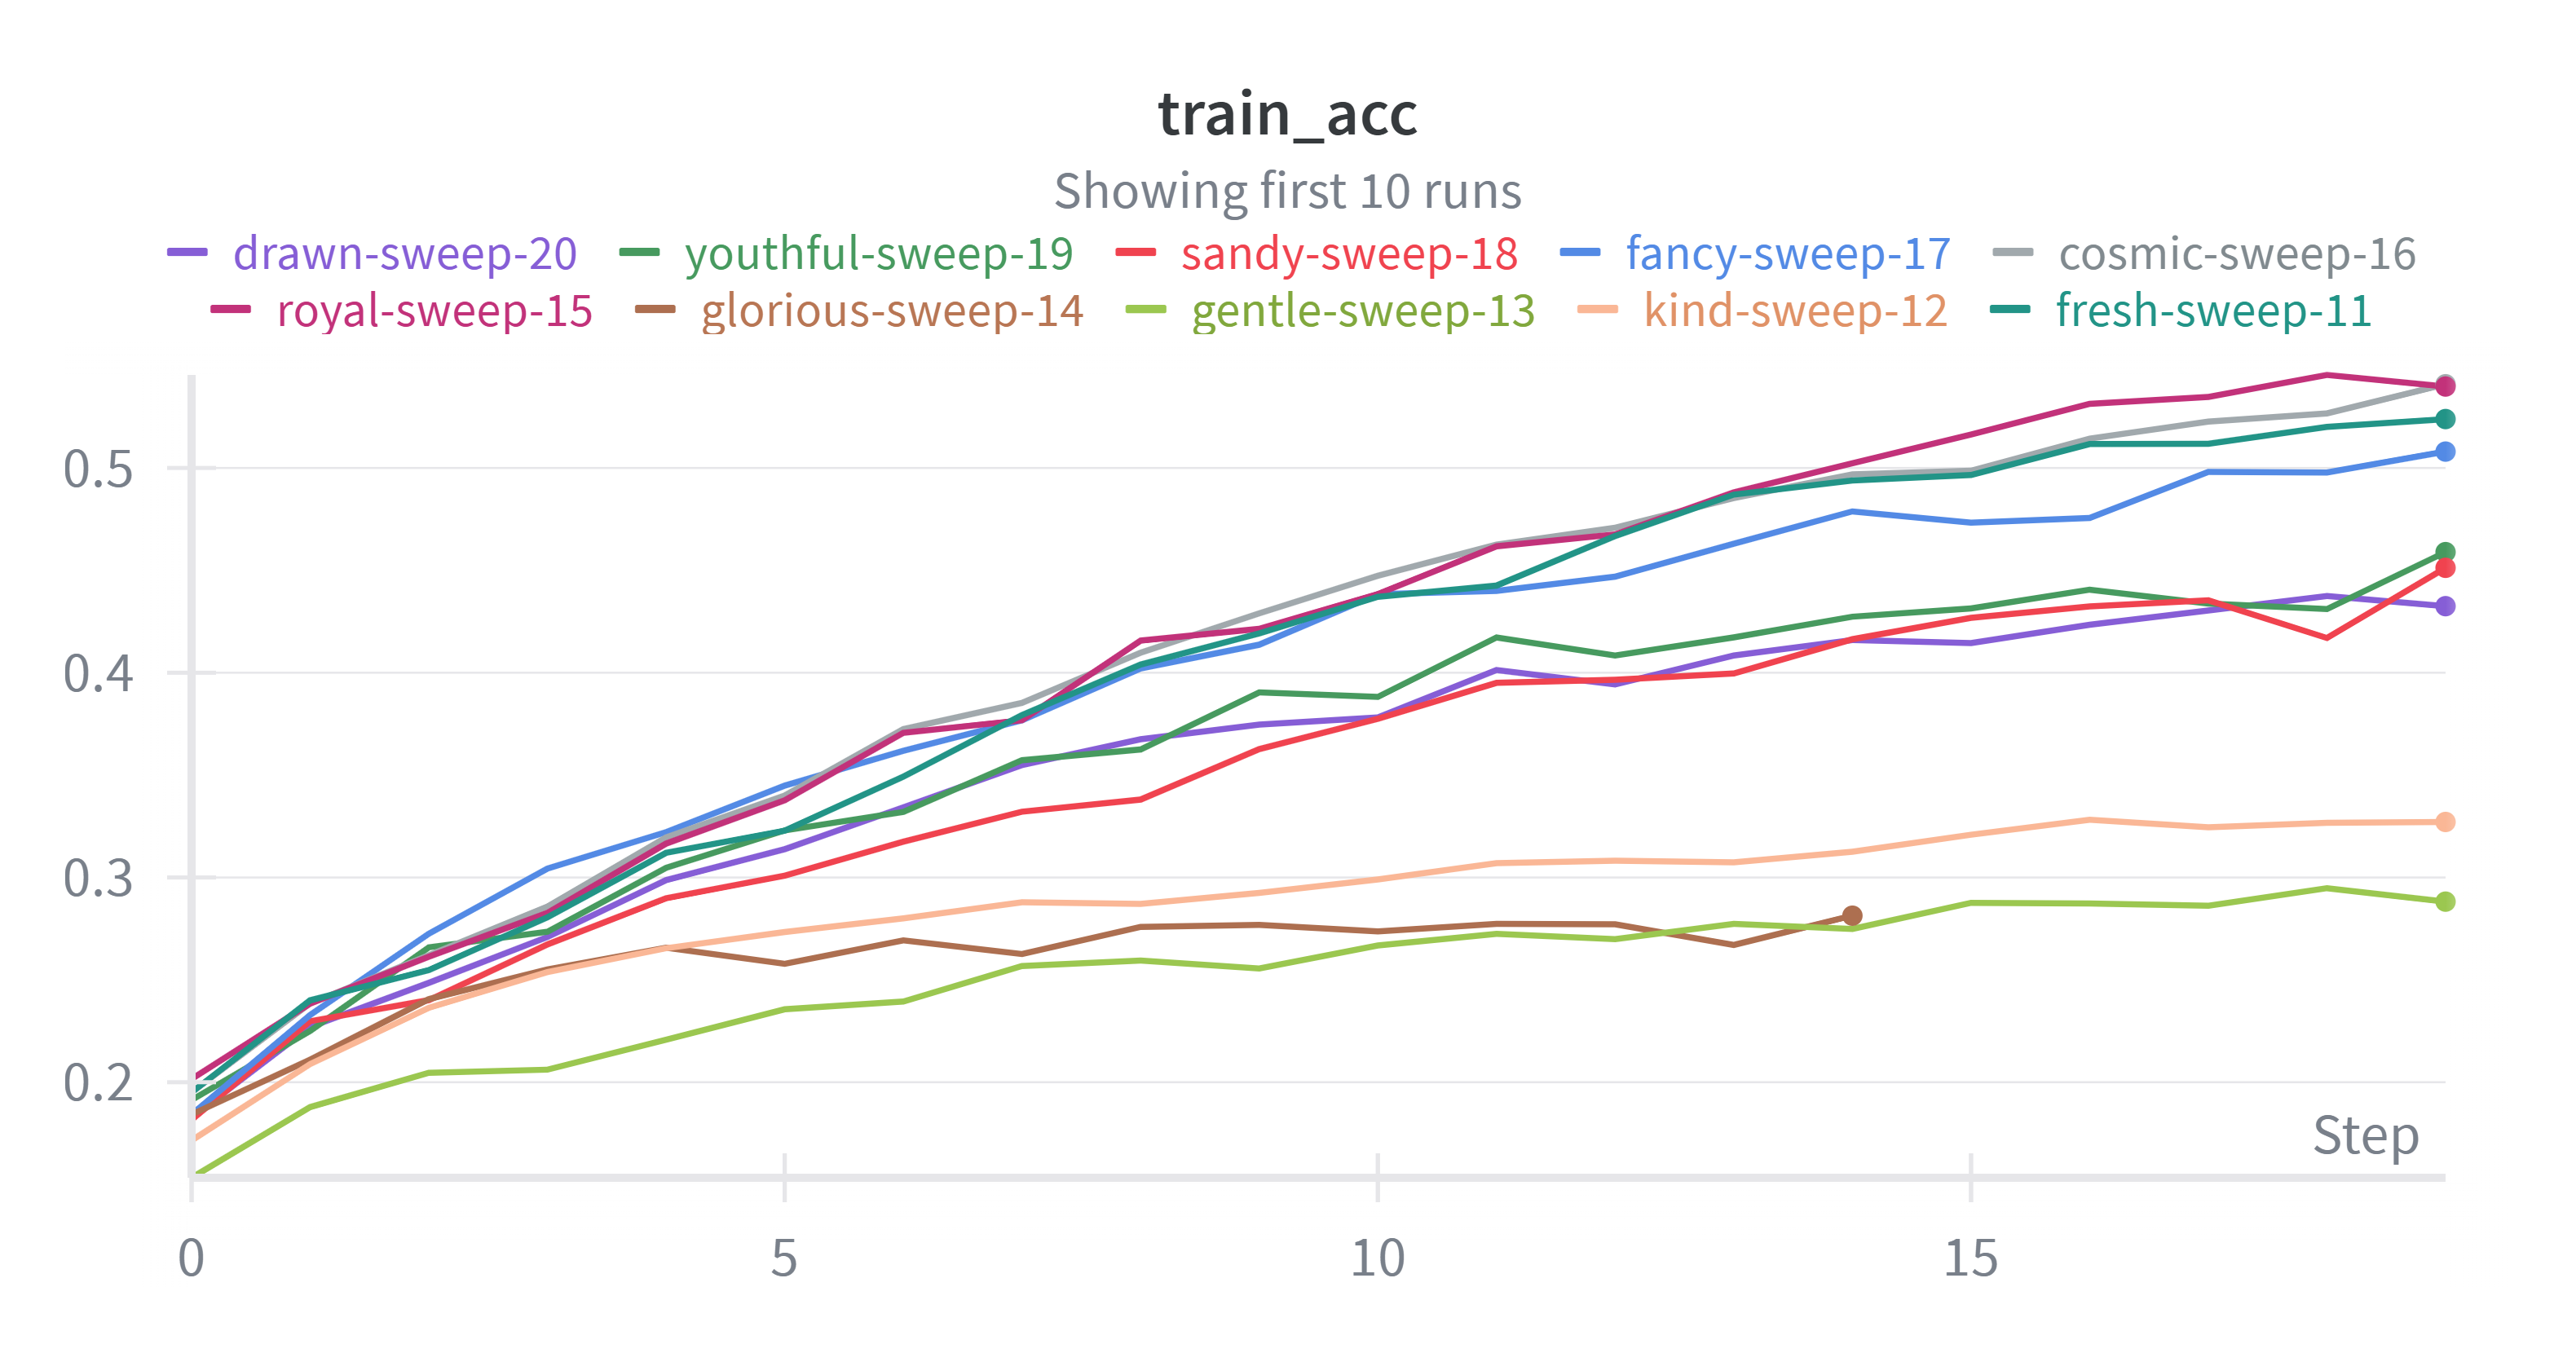

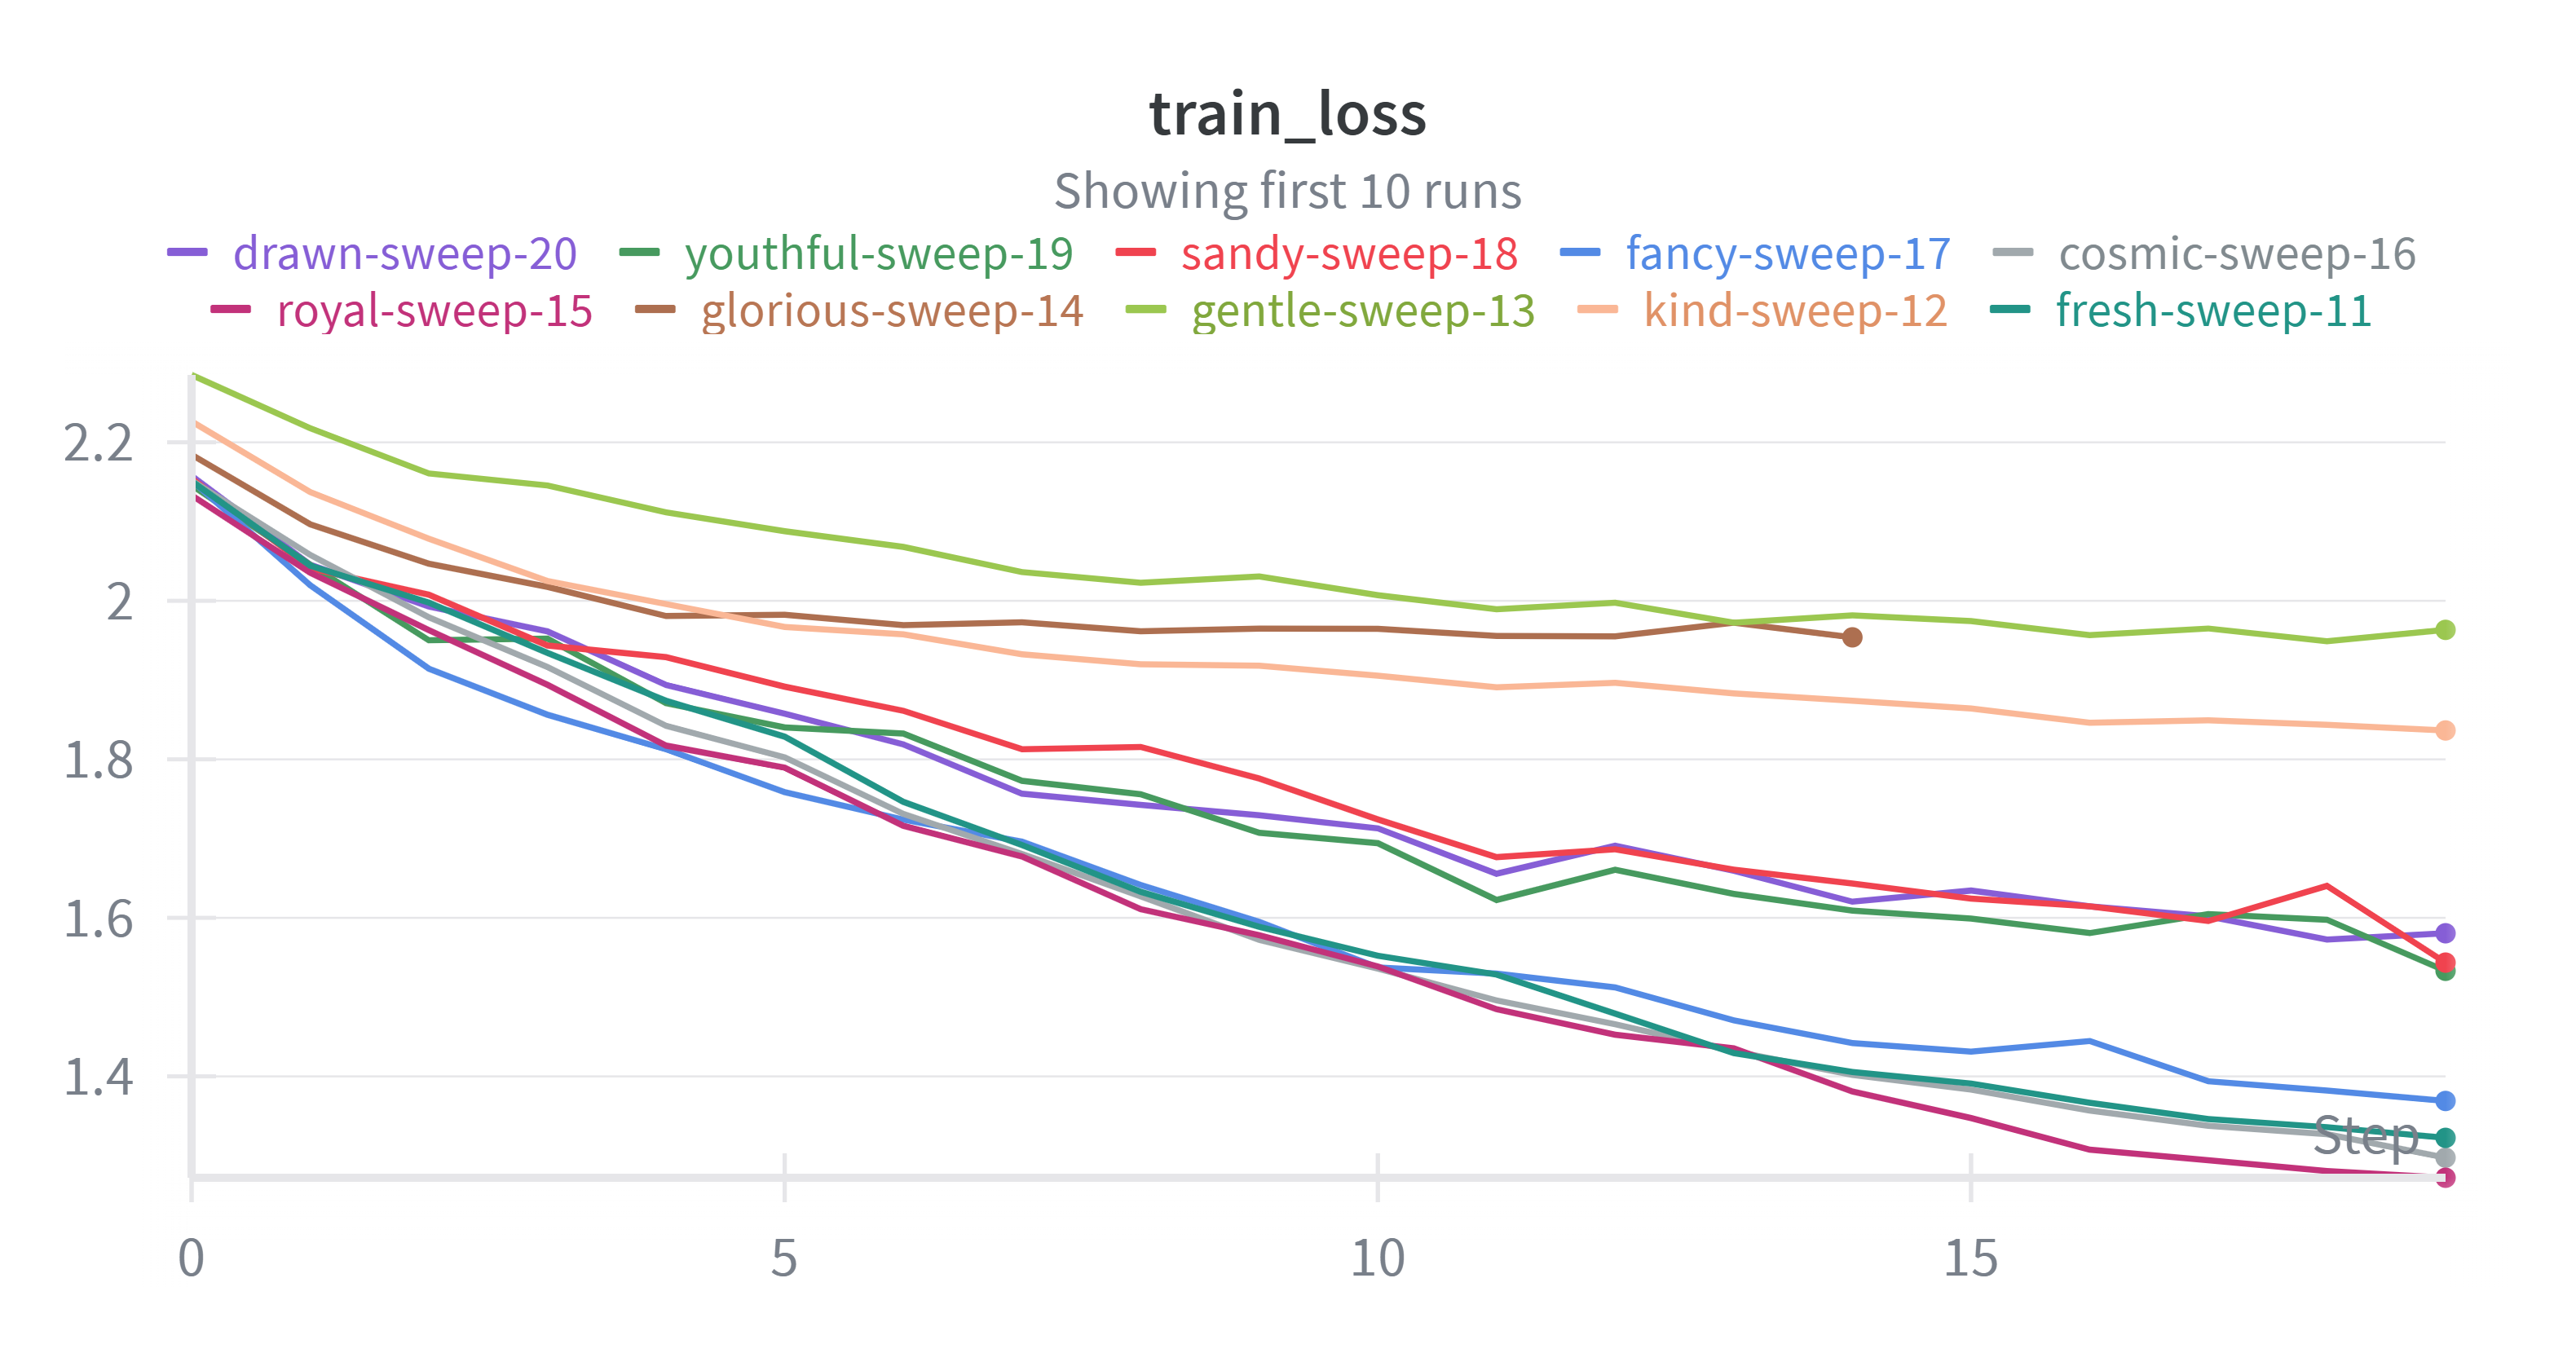

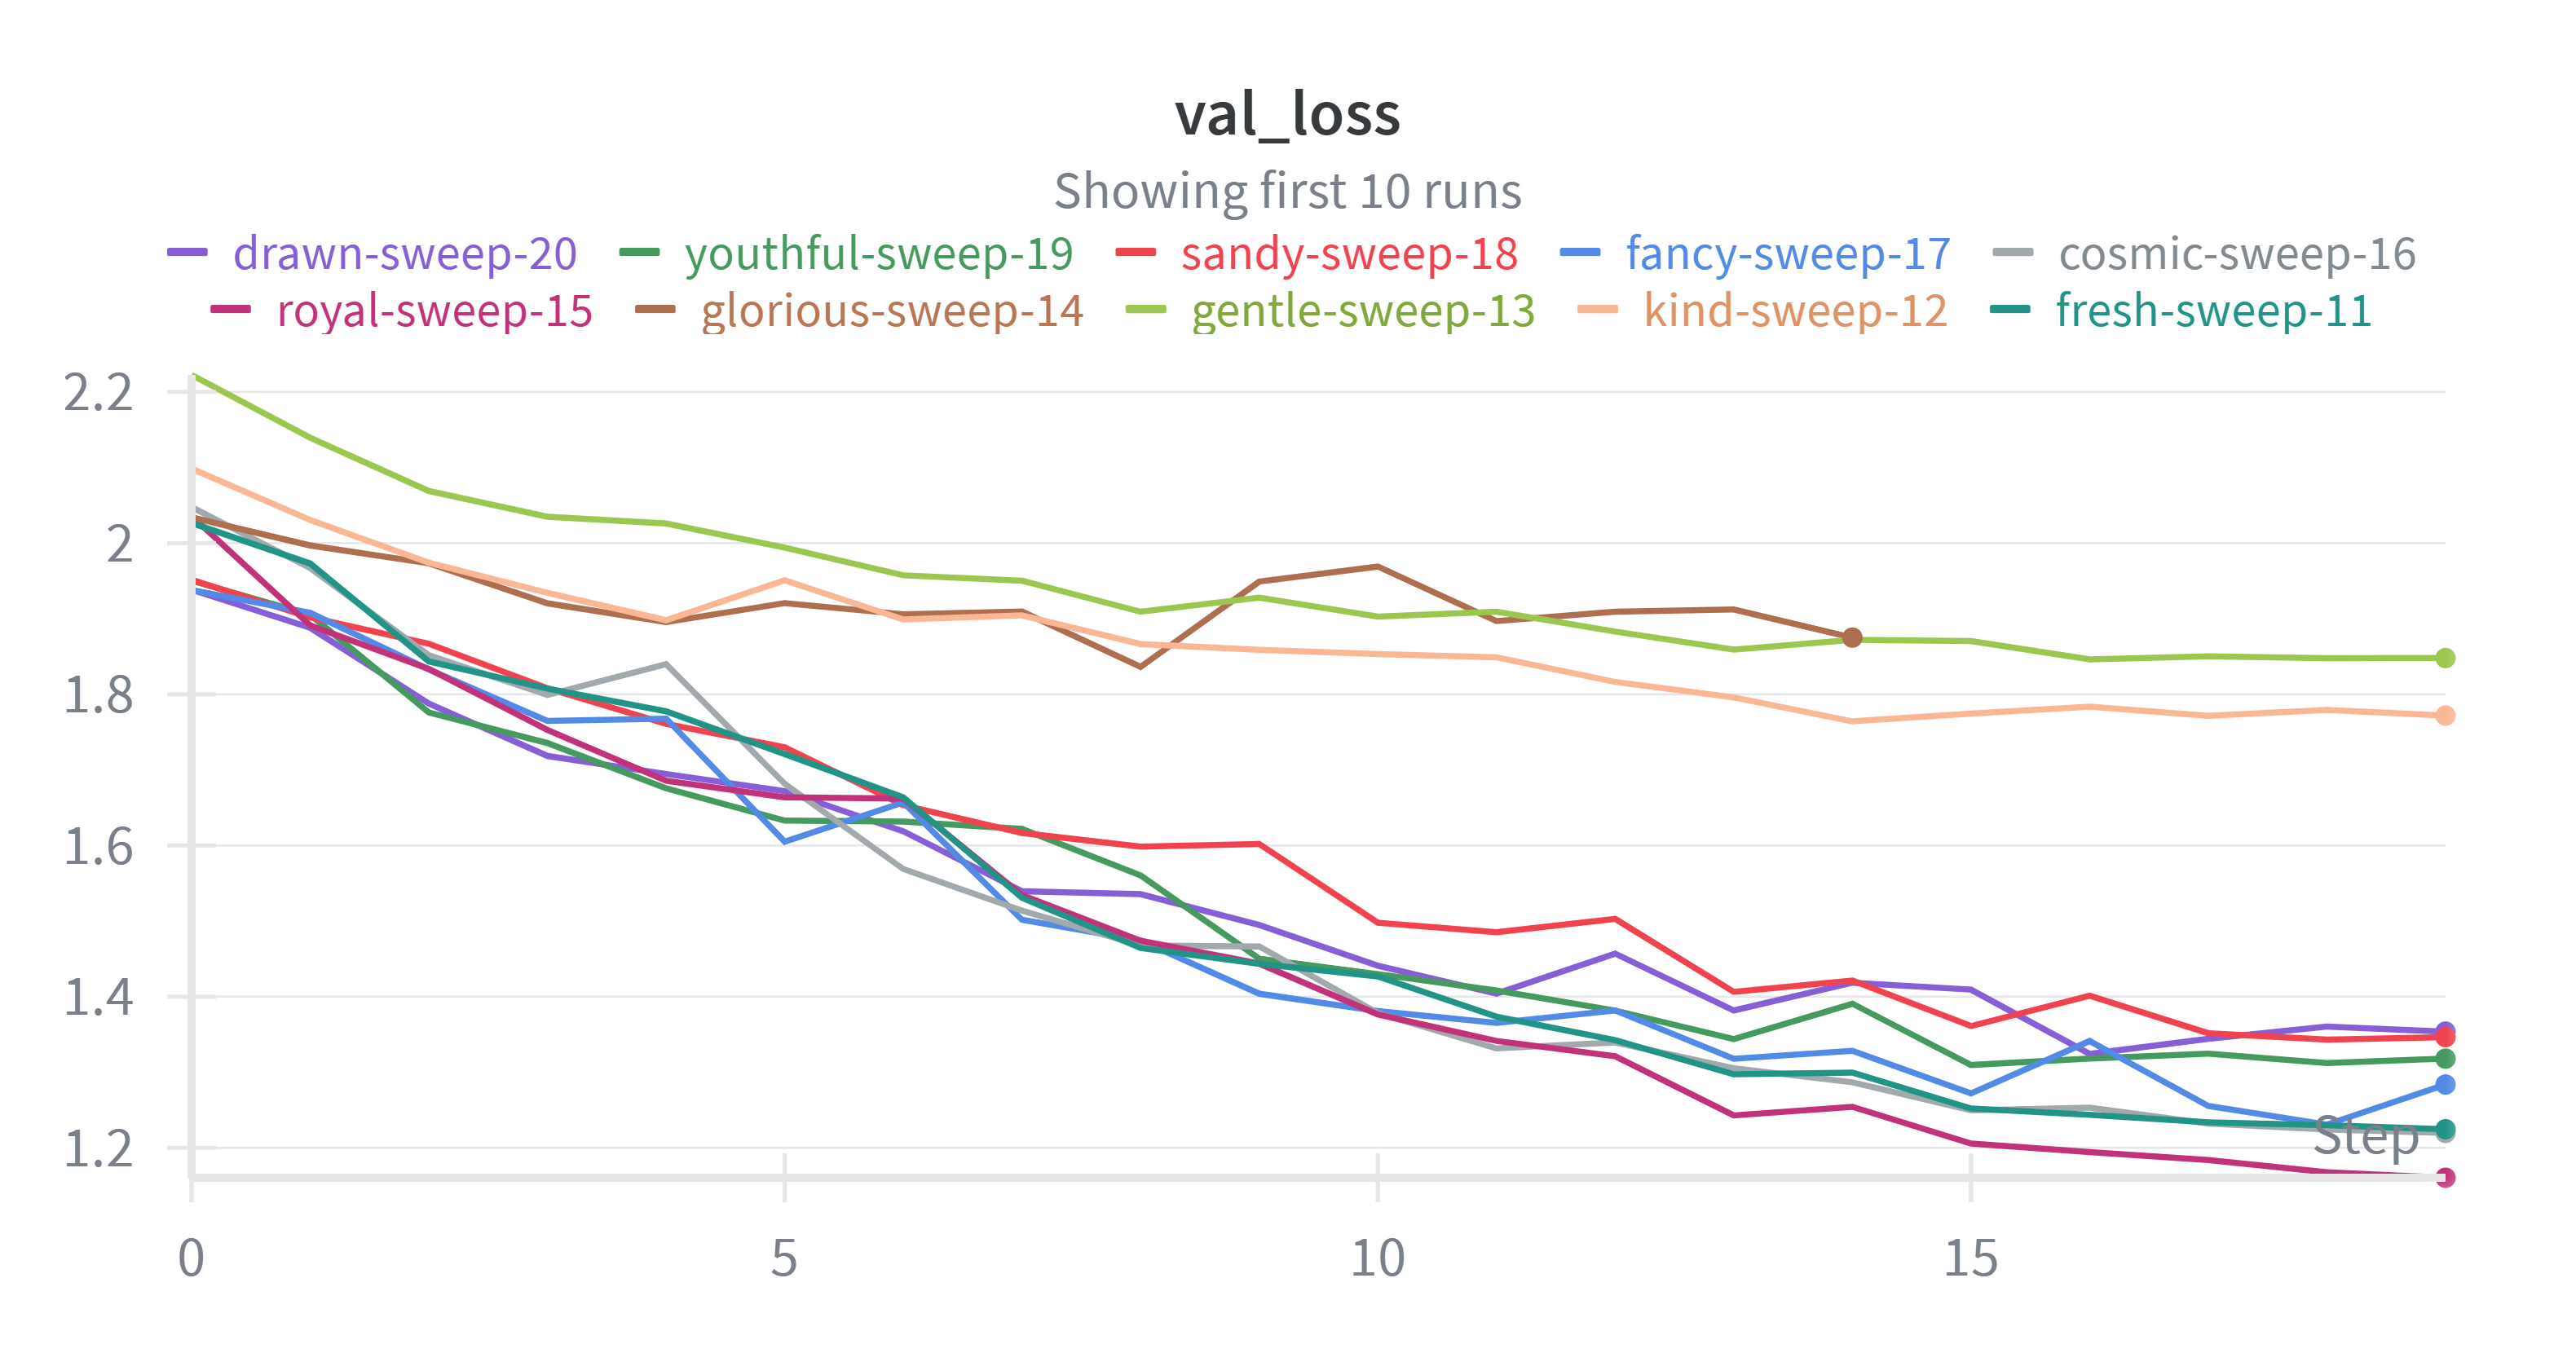

In [3]:
from IPython.display import Image, display

# Display images with reduced width (e.g., 400 pixels)
display(Image(filename='W&B Chart 10_5_2025, 1_56_59 AM.png', width=600))
display(Image(filename='W&B Chart 10_5_2025, 1_56_52 AM.png', width=600))
display(Image(filename='W&B Chart 10_5_2025, 1_56_39 AM.png', width=600))
display(Image(filename='W&B Chart 10_5_2025, 1_56_08 AM.png', width=600))



# STAGE 2 : Final Training / Model Refinement / Evaluation


In [2]:
from pathlib import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# # Folder to save Stage 1 sweep results
# SWEEP_SAVE_DIR = Path("/content/drive/MyDrive/vit_cifar10_sweep_results")
# SWEEP_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Folder to save full-dataset Stage 2 results
FULL_SAVE_DIR = Path("/content/drive/MyDrive/vit_cifar10_fulltrain_results")
FULL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# File to store top 3 configs for Stage 2
TOP_CONFIGS_FILE = Path("/content/drive/MyDrive/vit_cifar10_fulltrain_top3.json")

# print("Sweep results folder:", SWEEP_SAVE_DIR)
print("Full training results folder:", FULL_SAVE_DIR)
print("Top configs file:", TOP_CONFIGS_FILE)


Mounted at /content/drive
Full training results folder: /content/drive/MyDrive/vit_cifar10_fulltrain_results
Top configs file: /content/drive/MyDrive/vit_cifar10_fulltrain_top3.json


In [3]:
import os, time, random, json
from pathlib import Path
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit

# mixed precision
from torch.cuda.amp import autocast, GradScaler

# wandb
import wandb

# Seed for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [4]:

# Helper: pick a valid num_heads that divides embed_dim (closest to requested)
def pick_num_heads(embed_dim:int, requested_heads:int) -> int:
    # compute divisors
    divs = [d for d in range(1, embed_dim+1) if embed_dim % d == 0]
    # choose divisor closest to requested_heads (prefer <= requested if tie)
    best = min(divs, key=lambda d: (abs(d - requested_heads), -d))
    return best

class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=384, stride=None):
        super().__init__()
        stride = patch_size if stride is None else stride
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride)
        self.num_patches = (img_size // stride) * (img_size // stride)

    def forward(self, x):
        x = self.proj(x)            # B, C, H', W'
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1,2)  # B, N, C
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    def forward(self,x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x)
        return x

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        rand = keep + torch.rand(shape, device=x.device, dtype=x.dtype)
        rand.floor_()
        return x.div(keep) * rand

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.0, attn_drop=0.0, drop_path=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        # MultiheadAttention expects embed_dim divisible by num_heads
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True, dropout=attn_drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim*mlp_ratio), drop=drop)
    def forward(self, x):
        x_res = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x,x,x, need_weights=False)
        x = x_res + self.drop_path(attn_out)
        x_res = x
        x = self.norm2(x)
        x = x_res + self.drop_path(self.mlp(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self,
                 img_size=32, patch_size=4, stride=None, in_chans=3, num_classes=10,
                 embed_dim=256, depth=8, num_heads=4, mlp_ratio=4.0,
                 drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0):
        super().__init__()
        # ensure num_heads divides embed_dim
        if embed_dim % num_heads != 0:
            chosen = pick_num_heads(embed_dim, num_heads)
            print(f"[Info] Adjusting num_heads {num_heads} -> {chosen} to divide embed_dim {embed_dim}")
            num_heads = chosen

        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim, stride=stride)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))
        self.pos_drop = nn.Dropout(drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i])
            for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self,m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls_out = x[:,0]
        out = self.head(cls_out)
        return out


In [5]:
import numpy as np
from typing import Optional
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedShuffleSplit

from torchvision.transforms import RandAugment

def build_transforms(train=True, use_randaugment=True):
    if train:
        aug = []
        if use_randaugment:
            aug.append(RandAugment(num_ops=2, magnitude=9))
        aug += [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
        ]
        return transforms.Compose(aug)
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
        ])

def get_dataloaders(batch_size=128, num_workers=2, use_randaugment=True, subset_ratio:Optional[float]=None):
    full_transform_train = build_transforms(train=True, use_randaugment=use_randaugment)
    test_transform = build_transforms(train=False, use_randaugment=False)

    # Full training dataset (50k images)
    full_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=full_transform_train)
    targets = np.array(full_dataset.targets)

    # Stratified 10% validation split (~5k val, 45k train)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    train_idx_full, val_idx = next(sss.split(np.zeros(len(targets)), targets))

    # Stage-1 proxy subset (if used)
    if subset_ratio is not None and 0 < subset_ratio < 1.0:
        targets_train_full = targets[train_idx_full]
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=1.0-subset_ratio, random_state=42)
        sub_idx_rel, _ = next(sss2.split(np.zeros(len(targets_train_full)), targets_train_full))
        train_idx = train_idx_full[sub_idx_rel]
    else:
        train_idx = train_idx_full

    train_dataset = Subset(full_dataset, train_idx)
    val_dataset_full = datasets.CIFAR10(root="./data", train=True, download=False, transform=test_transform)
    val_dataset = Subset(val_dataset_full, val_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
    return train_loader, val_loader

def get_test_loader(batch_size=128, num_workers=2):
    test_transform = build_transforms(train=False, use_randaugment=False)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=True)
    print(f"Test samples: {len(test_dataset)}")
    return test_loader


In [6]:
# Colab cell 4
def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, None, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    idx = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_one_epoch(model, loader, optimizer, criterion, scaler, device, epoch, config):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()

        if config.get("mixup_alpha", 0.0) > 0:
            images, targets_a, targets_b, lam = mixup_data(images, targets, alpha=config["mixup_alpha"])
        else:
            lam = None

        with autocast():
            outputs = model(images)
            if lam is not None:
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        if config.get("grad_clip", 0.0) > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config["grad_clip"])
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        if lam is not None:
            correct += (lam * preds.eq(targets_a).sum().item() + (1 - lam) * preds.eq(targets_b).sum().item())
        else:
            correct += preds.eq(targets).sum().item()
        total += images.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, targets)
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += images.size(0)
    return running_loss/total, correct/total


In [7]:
# Colab cell 5
class EarlyStopping:
    def __init__(self, patience=8, mode="max", min_delta=1e-4):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = -float("inf") if mode=="max" else float("inf")
        self.num_bad = 0
    def step(self, metric):
        improved = (metric > self.best + self.min_delta) if self.mode=="max" else (metric < self.best - self.min_delta)
        if improved:
            self.best = metric
            self.num_bad = 0
            return False
        else:
            self.num_bad += 1
            return self.num_bad >= self.patience

class ModelCheckpoint:
    def __init__(self, path="best.pth"):
        self.path = path
        self.best = -float("inf")
    def step(self, metric, model, optimizer=None, epoch=None):
        if metric > self.best:
            self.best = metric
            state = {"model_state": model.state_dict(), "optim_state": optimizer.state_dict() if optimizer else None, "epoch": epoch}
            torch.save(state, self.path)
            return True
        return False

from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, StepLR, SequentialLR
def get_scheduler(optimizer, name, epochs, warmup_epochs=5, step_size=30):
    if name == "cosine":
        if warmup_epochs > 0:
            def warmup_lambda(ep): return float(ep+1)/float(max(1,warmup_epochs))
            warm = LambdaLR(optimizer, lr_lambda=warmup_lambda)
            cosine = CosineAnnealingLR(optimizer, T_max=max(1, epochs - warmup_epochs))
            scheduler = SequentialLR(optimizer, schedulers=[warm, cosine], milestones=[warmup_epochs])
        else:
            scheduler = CosineAnnealingLR(optimizer, T_max=max(1, epochs))
    elif name == "step":
        scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)
    else:
        scheduler = None
    return scheduler


In [8]:
import json

# Load top-3 configs from Drive
with open(TOP_CONFIGS_FILE, "r") as f:
    top_configs = json.load(f)

print(f"Loaded {len(top_configs)} top configs:")
for i, cfg in enumerate(top_configs, 1):
    print(f"\n=== Top {i} Config ===")
    import pprint
    pprint.pprint(cfg)


Loaded 3 top configs:

=== Top 1 Config ===
{'batch_size': 64,
 'depth': 4,
 'drop_path_rate': 0.1,
 'drop_rate': 0,
 'embed_dim': 128,
 'epochs': 20,
 'grad_clip': 0,
 'img_size': 32,
 'lr': 0.0006496504019077107,
 'mixup_alpha': 0,
 'mlp_ratio': 4,
 'momentum': 0.9,
 'num_heads': 4,
 'num_workers': 2,
 'optimizer': 'adamw',
 'patch_size': 2,
 'patience': 6,
 'scheduler': 'cosine',
 'step_size': 30,
 'stride': None,
 'subset_ratio': 0.2,
 'use_randaugment': True,
 'warmup_epochs': 5,
 'weight_decay': 0.05}

=== Top 2 Config ===
{'batch_size': 128,
 'depth': 6,
 'drop_path_rate': 0.1,
 'drop_rate': 0,
 'embed_dim': 128,
 'epochs': 20,
 'grad_clip': 0,
 'img_size': 32,
 'lr': 0.0005836440175403633,
 'mixup_alpha': 0,
 'mlp_ratio': 4,
 'momentum': 0.9,
 'num_heads': 4,
 'num_workers': 2,
 'optimizer': 'adamw',
 'patch_size': 4,
 'patience': 6,
 'scheduler': 'cosine',
 'step_size': 30,
 'stride': None,
 'subset_ratio': 0.2,
 'use_randaugment': True,
 'warmup_epochs': 5,
 'weight_decay': 0

# Training function

In [9]:
import torch
from torch import nn
from torch.cuda.amp import GradScaler
import time
import wandb
import os

# Ensure your VisionTransformer, EarlyStopping, ModelCheckpoint, get_scheduler, train_one_epoch, validate are defined

def run_fulltrain(config, save_dir=FULL_SAVE_DIR, project_name="vit_cifar10_fulltrain_12_15"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Merge with defaults
    default = {
        "epochs": 50, "batch_size": 128, "img_size":32, "patch_size":4, "stride":None,
        "embed_dim":128, "depth":4, "num_heads":2, "mlp_ratio":4.0, "drop_rate":0.0, "drop_path_rate":0.1,
        "lr":1e-3, "weight_decay":0.05, "optimizer":"adamw", "momentum":0.9,
        "scheduler":"cosine", "warmup_epochs":5, "step_size":30, "mixup_alpha":0.0,
        "use_randaugment":True, "grad_clip":0.0, "patience":6, "num_workers":2, "subset_ratio":1.0
    }
    for k,v in default.items():
        config.setdefault(k,v)

    run = wandb.init(
        project=project_name,
        entity="kotasathvik7",
        config=config,
        name=f"fulltrain_{wandb.util.generate_id()}",
        reinit=True
    )
    cfg = wandb.config

    train_loader, val_loader = get_dataloaders(batch_size=cfg.batch_size,
                                               num_workers=cfg.num_workers,
                                               use_randaugment=cfg.use_randaugment,
                                               subset_ratio=cfg.subset_ratio)

    model = VisionTransformer(img_size=cfg.img_size, patch_size=cfg.patch_size, stride=cfg.stride,
                              num_classes=10, embed_dim=cfg.embed_dim, depth=cfg.depth,
                              num_heads=cfg.num_heads, mlp_ratio=cfg.mlp_ratio,
                              drop_rate=cfg.drop_rate, drop_path_rate=cfg.drop_path_rate).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay) \
        if cfg.optimizer=="adamw" else torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
    scheduler = get_scheduler(optimizer, cfg.scheduler, cfg.epochs, warmup_epochs=cfg.warmup_epochs, step_size=cfg.step_size)

    scaler = GradScaler()
    early_stopper = EarlyStopping(patience=cfg.patience, mode="max")
    ckpt = ModelCheckpoint(path="best_model.pth")

    best_val_acc = 0.0
    for epoch in range(cfg.epochs):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device, epoch, cfg)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        if scheduler is not None:
            try: scheduler.step()
            except: pass

        if ckpt.step(val_acc, model, optimizer, epoch):
            best_val_acc = val_acc

        wandb.log({"epoch":epoch, "train_loss":train_loss, "train_acc":train_acc,
                   "val_loss":val_loss, "val_acc":val_acc})

        print(f"[{epoch+1}/{cfg.epochs}] train_acc={train_acc:.4f} val_acc={val_acc:.4f} time={time.time()-t0:.1f}s")

        if early_stopper.step(val_acc):
            print("Early stopping triggered")
            break

    # Save checkpoint and results
    if os.path.exists("best_model.pth"):
        torch.save({
            "config": dict(cfg),
            "model_state_dict": model.state_dict(),
            "best_val_acc": best_val_acc
        }, save_dir/f"{wandb.run.id}.pth")
        print("Saved run results to Drive:", save_dir/f"{wandb.run.id}.pth")

    wandb.summary["best_val_acc"] = best_val_acc
    wandb.finish()
    return model, best_val_acc


# Running more epochs with relaxed early stopping

In [11]:
# Increase epochs to 50 for each of the top 3 configs
for i, cfg in enumerate(top_configs):
    old_epochs = cfg.get("epochs", None)
    cfg["epochs"] = 120
    cfg["subset_ratio"] = 1.0
    cfg["patience"]=15
    # early_stopper = EarlyStopping(patience=cfg.patience, mode="max")
    print(f"Config {i+1}: epochs changed from {old_epochs} -> {cfg['epochs']}")


Config 1: epochs changed from 120 -> 120
Config 2: epochs changed from 20 -> 120
Config 3: epochs changed from 20 -> 120


# Model Evaluation  and Performance Metrics


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)

    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return acc, cm


# Automated Training Sweep (Top 3 Configurations)
**Train_acc, Train_loss, Valid_acc, Valid_loss Line Plots**  
(45,000 Train samples • 5,000 Validation samples • 10,000 Test samples)

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


Test samples: 10000

=== Running top1_fulltrain on full dataset ===


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kotasathvik25 (kotasathvik7) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Train samples: 45000, Val samples: 5000


/tmp/ipython-input-2170800419.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/120] train_acc=0.2776 val_acc=0.3904 time=47.1s
[2/120] train_acc=0.3766 val_acc=0.4858 time=44.7s
[3/120] train_acc=0.4314 val_acc=0.5212 time=44.8s
[4/120] train_acc=0.4669 val_acc=0.5384 time=44.8s
[5/120] train_acc=0.4848 val_acc=0.5322 time=46.5s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/120] train_acc=0.5082 val_acc=0.5886 time=44.2s
[7/120] train_acc=0.5256 val_acc=0.6068 time=44.3s
[8/120] train_acc=0.5433 val_acc=0.6148 time=44.4s
[9/120] train_acc=0.5582 val_acc=0.6354 time=44.7s
[10/120] train_acc=0.5728 val_acc=0.6484 time=46.4s
[11/120] train_acc=0.5824 val_acc=0.6334 time=44.3s
[12/120] train_acc=0.5917 val_acc=0.6612 time=44.3s
[13/120] train_acc=0.6017 val_acc=0.6680 time=44.4s
[14/120] train_acc=0.6077 val_acc=0.6770 time=44.7s
[15/120] train_acc=0.6158 val_acc=0.6878 time=46.1s
[16/120] train_acc=0.6239 val_acc=0.6922 time=44.9s
[17/120] train_acc=0.6270 val_acc=0.6970 time=44.8s
[18/120] train_acc=0.6350 val_acc=0.6772 time=44.5s
[19/120] train_acc=0.6397 val_acc=0.6972 time=44.9s
[20/120] train_acc=0.6464 val_acc=0.7026 time=47.0s
[21/120] train_acc=0.6511 val_acc=0.7272 time=44.8s
[22/120] train_acc=0.6583 val_acc=0.7200 time=44.5s
[23/120] train_acc=0.6624 val_acc=0.7048 time=44.6s
[24/120] train_acc=0.6666 val_acc=0.7276 time=45.3s
[25/120] train_a

Completed top1_fulltrain: best_val_acc=0.8474
Test Accuracy: 0.8430

Classification Report:
              precision    recall  f1-score   support

       plane       0.87      0.87      0.87      1000
         car       0.92      0.92      0.92      1000
        bird       0.82      0.76      0.79      1000
         cat       0.70      0.69      0.70      1000
        deer       0.80      0.84      0.82      1000
         dog       0.76      0.78      0.77      1000
        frog       0.87      0.89      0.88      1000
       horse       0.90      0.87      0.88      1000
        ship       0.91      0.91      0.91      1000
       truck       0.89      0.91      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000




=== Running top2_fulltrain on full dataset ===


Train samples: 45000, Val samples: 5000


/tmp/ipython-input-2170800419.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/120] train_acc=0.2677 val_acc=0.3714 time=39.2s
[2/120] train_acc=0.3593 val_acc=0.4558 time=39.0s
[3/120] train_acc=0.4217 val_acc=0.5270 time=40.1s
[4/120] train_acc=0.4528 val_acc=0.5524 time=42.0s
[5/120] train_acc=0.4749 val_acc=0.5636 time=38.5s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/120] train_acc=0.4956 val_acc=0.5810 time=40.6s
[7/120] train_acc=0.5181 val_acc=0.5946 time=40.7s
[8/120] train_acc=0.5345 val_acc=0.6142 time=39.0s
[9/120] train_acc=0.5462 val_acc=0.6328 time=42.4s
[10/120] train_acc=0.5592 val_acc=0.6364 time=40.1s
[11/120] train_acc=0.5709 val_acc=0.6474 time=40.1s
[12/120] train_acc=0.5809 val_acc=0.6634 time=38.8s
[13/120] train_acc=0.5980 val_acc=0.6550 time=40.5s
[14/120] train_acc=0.6062 val_acc=0.6844 time=40.0s
[15/120] train_acc=0.6142 val_acc=0.6780 time=40.8s
[16/120] train_acc=0.6273 val_acc=0.6958 time=41.0s
[17/120] train_acc=0.6335 val_acc=0.7052 time=42.2s
[18/120] train_acc=0.6470 val_acc=0.7156 time=39.4s
[19/120] train_acc=0.6570 val_acc=0.7276 time=40.7s
[20/120] train_acc=0.6611 val_acc=0.7308 time=41.9s
[21/120] train_acc=0.6696 val_acc=0.7360 time=40.2s
[22/120] train_acc=0.6751 val_acc=0.7502 time=39.4s
[23/120] train_acc=0.6809 val_acc=0.7298 time=40.5s
[24/120] train_acc=0.6896 val_acc=0.7432 time=40.1s
[25/120] train_a

Completed top2_fulltrain: best_val_acc=0.8686
Test Accuracy: 0.8722

Classification Report:
              precision    recall  f1-score   support

       plane       0.89      0.89      0.89      1000
         car       0.94      0.92      0.93      1000
        bird       0.86      0.83      0.84      1000
         cat       0.75      0.75      0.75      1000
        deer       0.85      0.86      0.86      1000
         dog       0.80      0.81      0.80      1000
        frog       0.92      0.90      0.91      1000
       horse       0.91      0.90      0.91      1000
        ship       0.92      0.93      0.93      1000
       truck       0.90      0.92      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



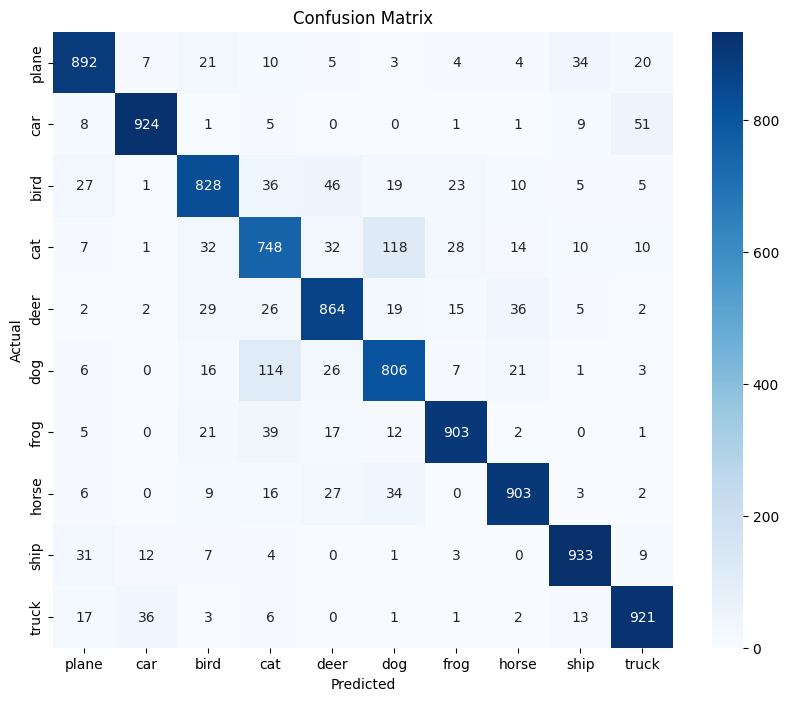


=== Running top3_fulltrain on full dataset ===


Train samples: 45000, Val samples: 5000


/tmp/ipython-input-2170800419.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2794130273.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2794130273.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[1/120] train_acc=0.2560 val_acc=0.3710 time=42.2s
[2/120] train_acc=0.3478 val_acc=0.4712 time=40.8s
[3/120] train_acc=0.4023 val_acc=0.5028 time=42.8s
[4/120] train_acc=0.4297 val_acc=0.5508 time=44.3s
[5/120] train_acc=0.4394 val_acc=0.5646 time=43.0s


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6/120] train_acc=0.4692 val_acc=0.5658 time=43.6s
[7/120] train_acc=0.4843 val_acc=0.5930 time=42.6s
[8/120] train_acc=0.5053 val_acc=0.6270 time=43.2s
[9/120] train_acc=0.5194 val_acc=0.6264 time=44.1s
[10/120] train_acc=0.5329 val_acc=0.6430 time=42.1s
[11/120] train_acc=0.5463 val_acc=0.6202 time=42.1s
[12/120] train_acc=0.5517 val_acc=0.6414 time=42.6s
[13/120] train_acc=0.5537 val_acc=0.6718 time=42.7s
[14/120] train_acc=0.5601 val_acc=0.6464 time=44.1s
[15/120] train_acc=0.5579 val_acc=0.6862 time=42.8s
[16/120] train_acc=0.5829 val_acc=0.6958 time=42.9s
[17/120] train_acc=0.5859 val_acc=0.6862 time=42.9s
[18/120] train_acc=0.5888 val_acc=0.7026 time=43.0s
[19/120] train_acc=0.6071 val_acc=0.7010 time=43.3s
[20/120] train_acc=0.5979 val_acc=0.7132 time=42.0s
[21/120] train_acc=0.6010 val_acc=0.7032 time=42.4s
[22/120] train_acc=0.6095 val_acc=0.7248 time=42.8s
[23/120] train_acc=0.6209 val_acc=0.7150 time=42.5s
[24/120] train_acc=0.6135 val_acc=0.7146 time=44.9s
[25/120] train_a

Completed top3_fulltrain: best_val_acc=0.8586
Test Accuracy: 0.8547

Classification Report:
              precision    recall  f1-score   support

       plane       0.85      0.88      0.87      1000
         car       0.92      0.93      0.92      1000
        bird       0.84      0.79      0.82      1000
         cat       0.74      0.71      0.73      1000
        deer       0.83      0.84      0.84      1000
         dog       0.76      0.79      0.78      1000
        frog       0.89      0.90      0.89      1000
       horse       0.88      0.88      0.88      1000
        ship       0.92      0.91      0.91      1000
       truck       0.90      0.90      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



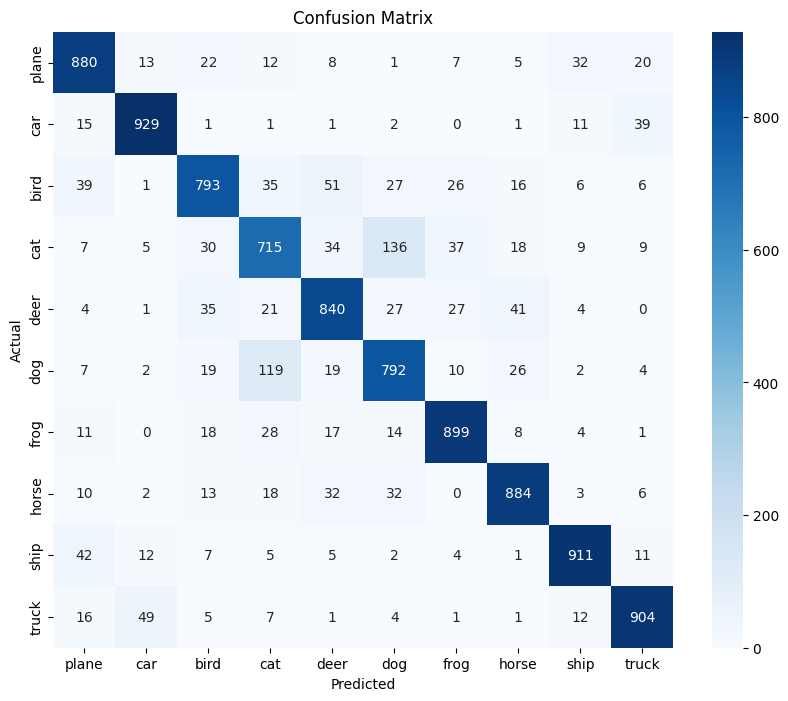

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = get_test_loader(batch_size=128)

classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

for i, cfg in enumerate(top_configs, 1):
    print(f"\n=== Running top{i}_fulltrain on full dataset ===")
    model, best_val = run_fulltrain(cfg, save_dir=FULL_SAVE_DIR, project_name="vit_cifar10_fulltrain_12_15")
    print(f"Completed top{i}_fulltrain: best_val_acc={best_val:.4f}")

    # Evaluate on 10k test set
    test_acc, cm = evaluate_model(model, test_loader, device, class_names=classes)


In [1]:
from google.colab import files
uploaded = files.upload()  # Then choose your image file


Saving W&B Chart 10_5_2025, 1_35_51 AM.png to W&B Chart 10_5_2025, 1_35_51 AM.png
Saving W&B Chart 10_5_2025, 1_35_39 AM.png to W&B Chart 10_5_2025, 1_35_39 AM.png
Saving W&B Chart 10_5_2025, 1_35_31 AM.png to W&B Chart 10_5_2025, 1_35_31 AM.png
Saving W&B Chart 10_5_2025, 1_35_18 AM.png to W&B Chart 10_5_2025, 1_35_18 AM.png
Saving W&B Chart 10_5_2025, 1_35_02 AM.png to W&B Chart 10_5_2025, 1_35_02 AM.png


# 📈 Stage 1: Train vs Validation Metrics  


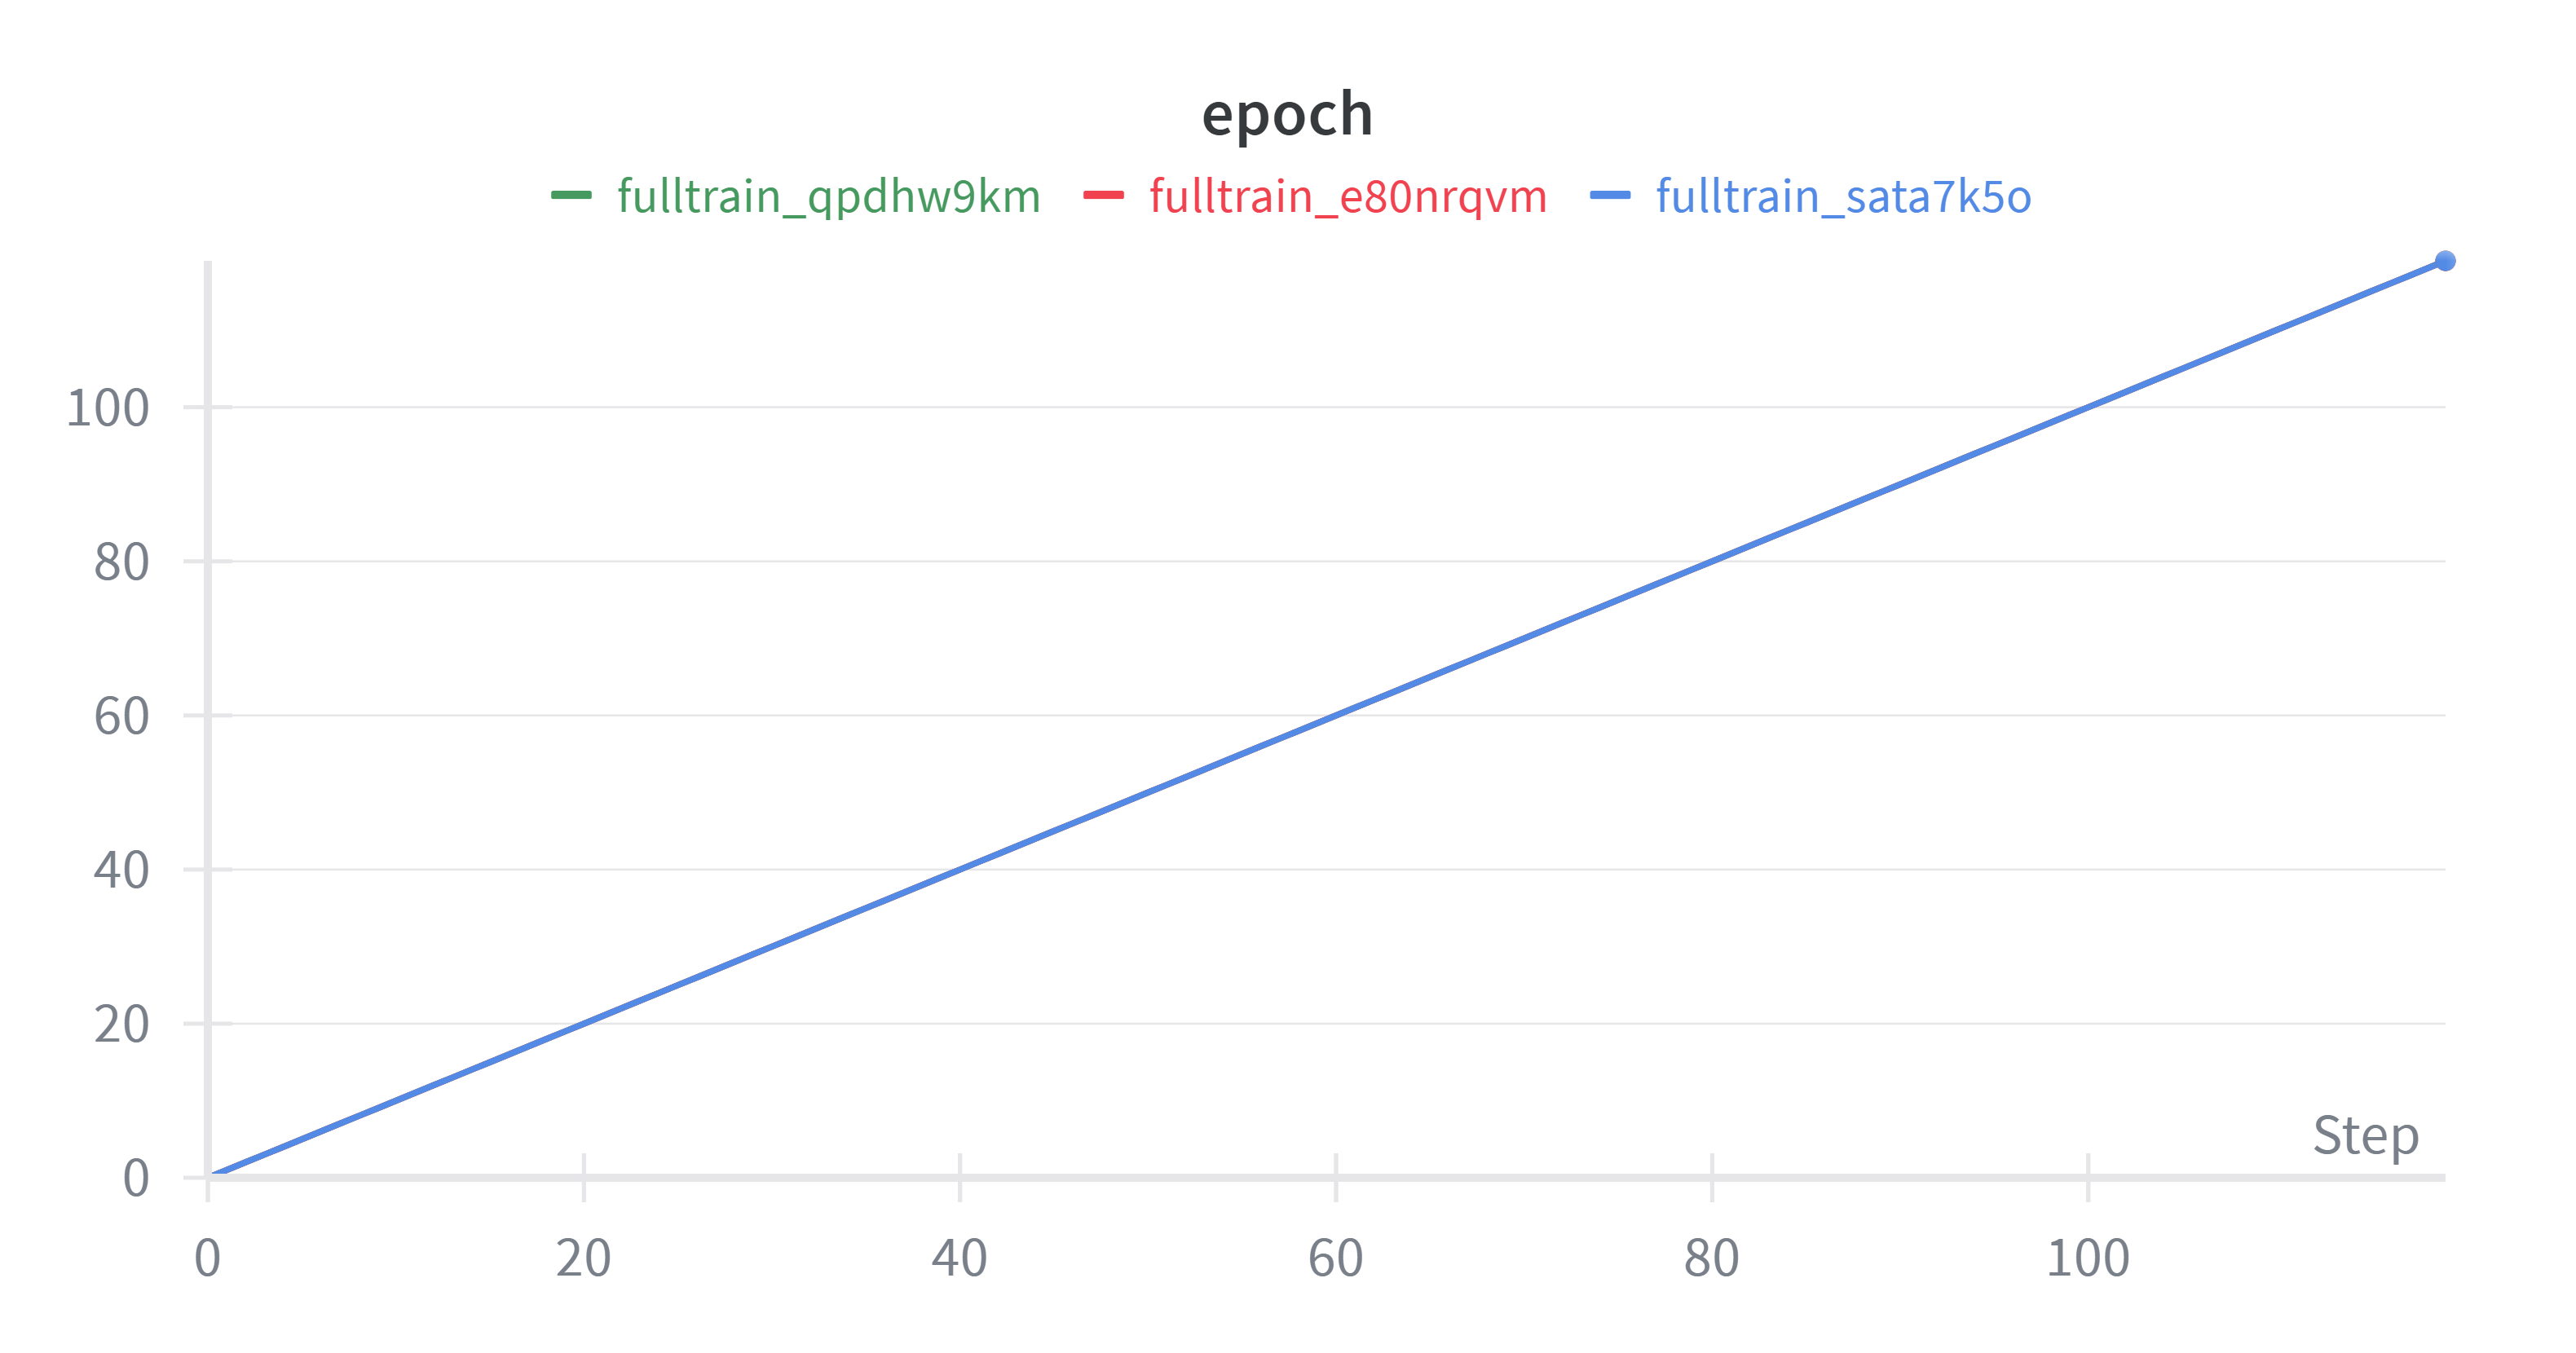

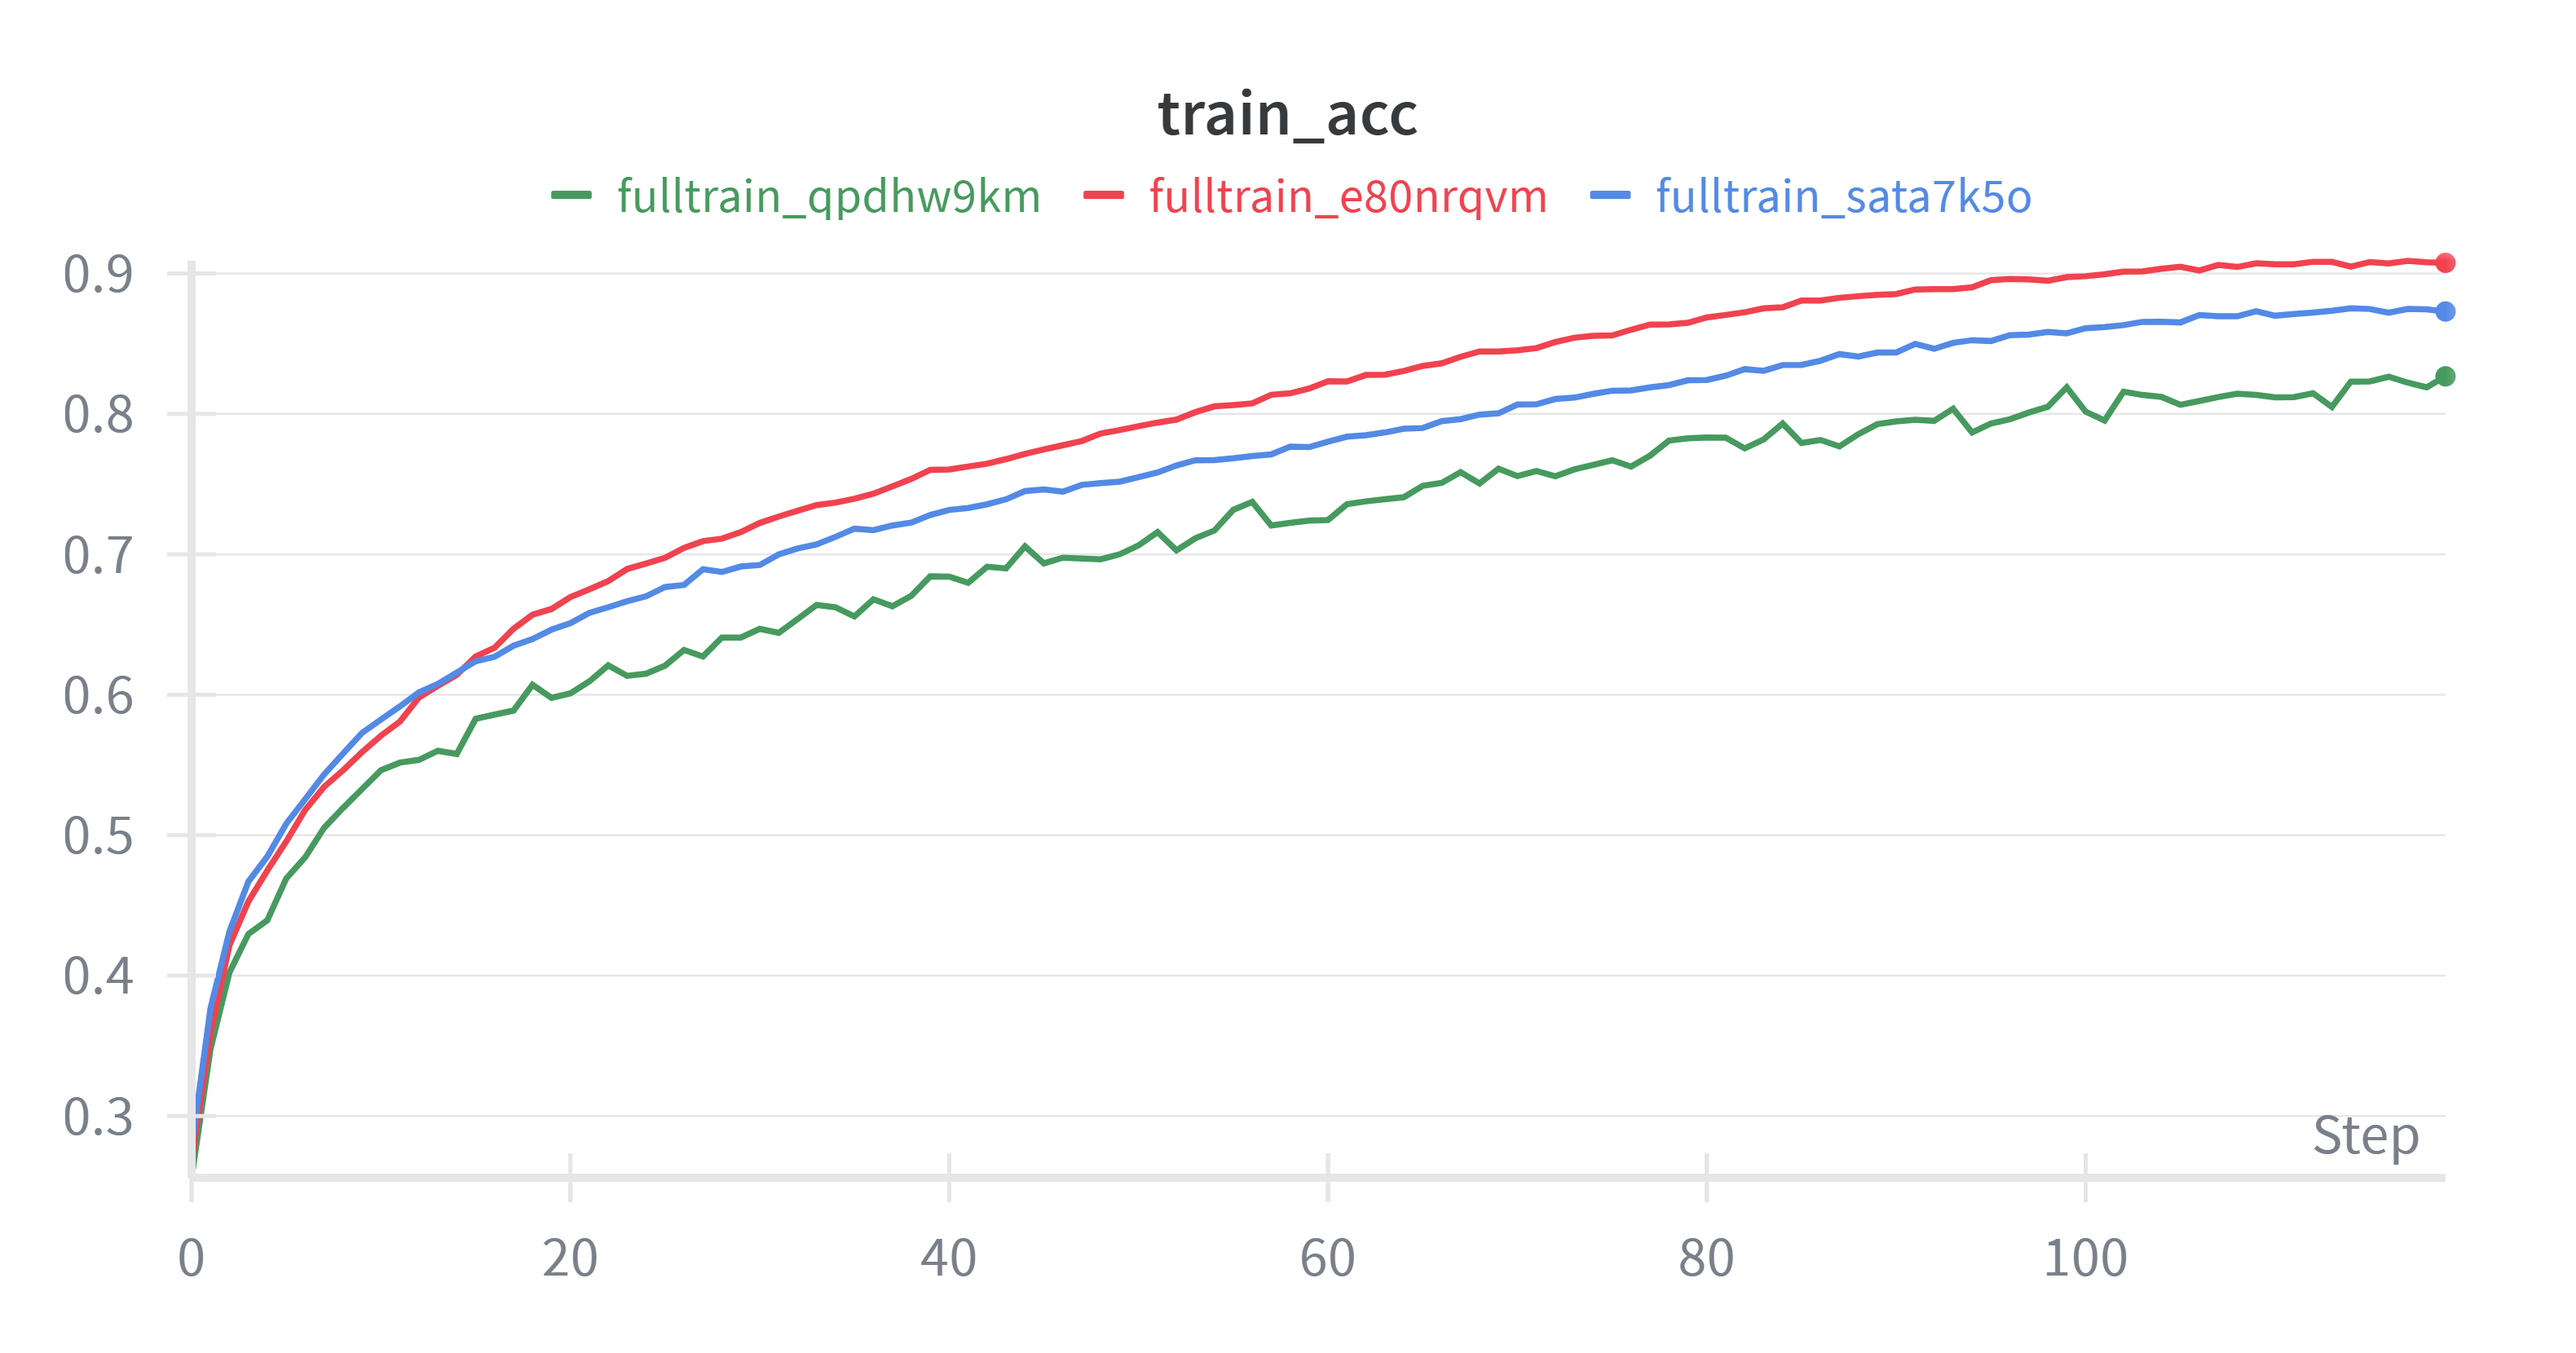

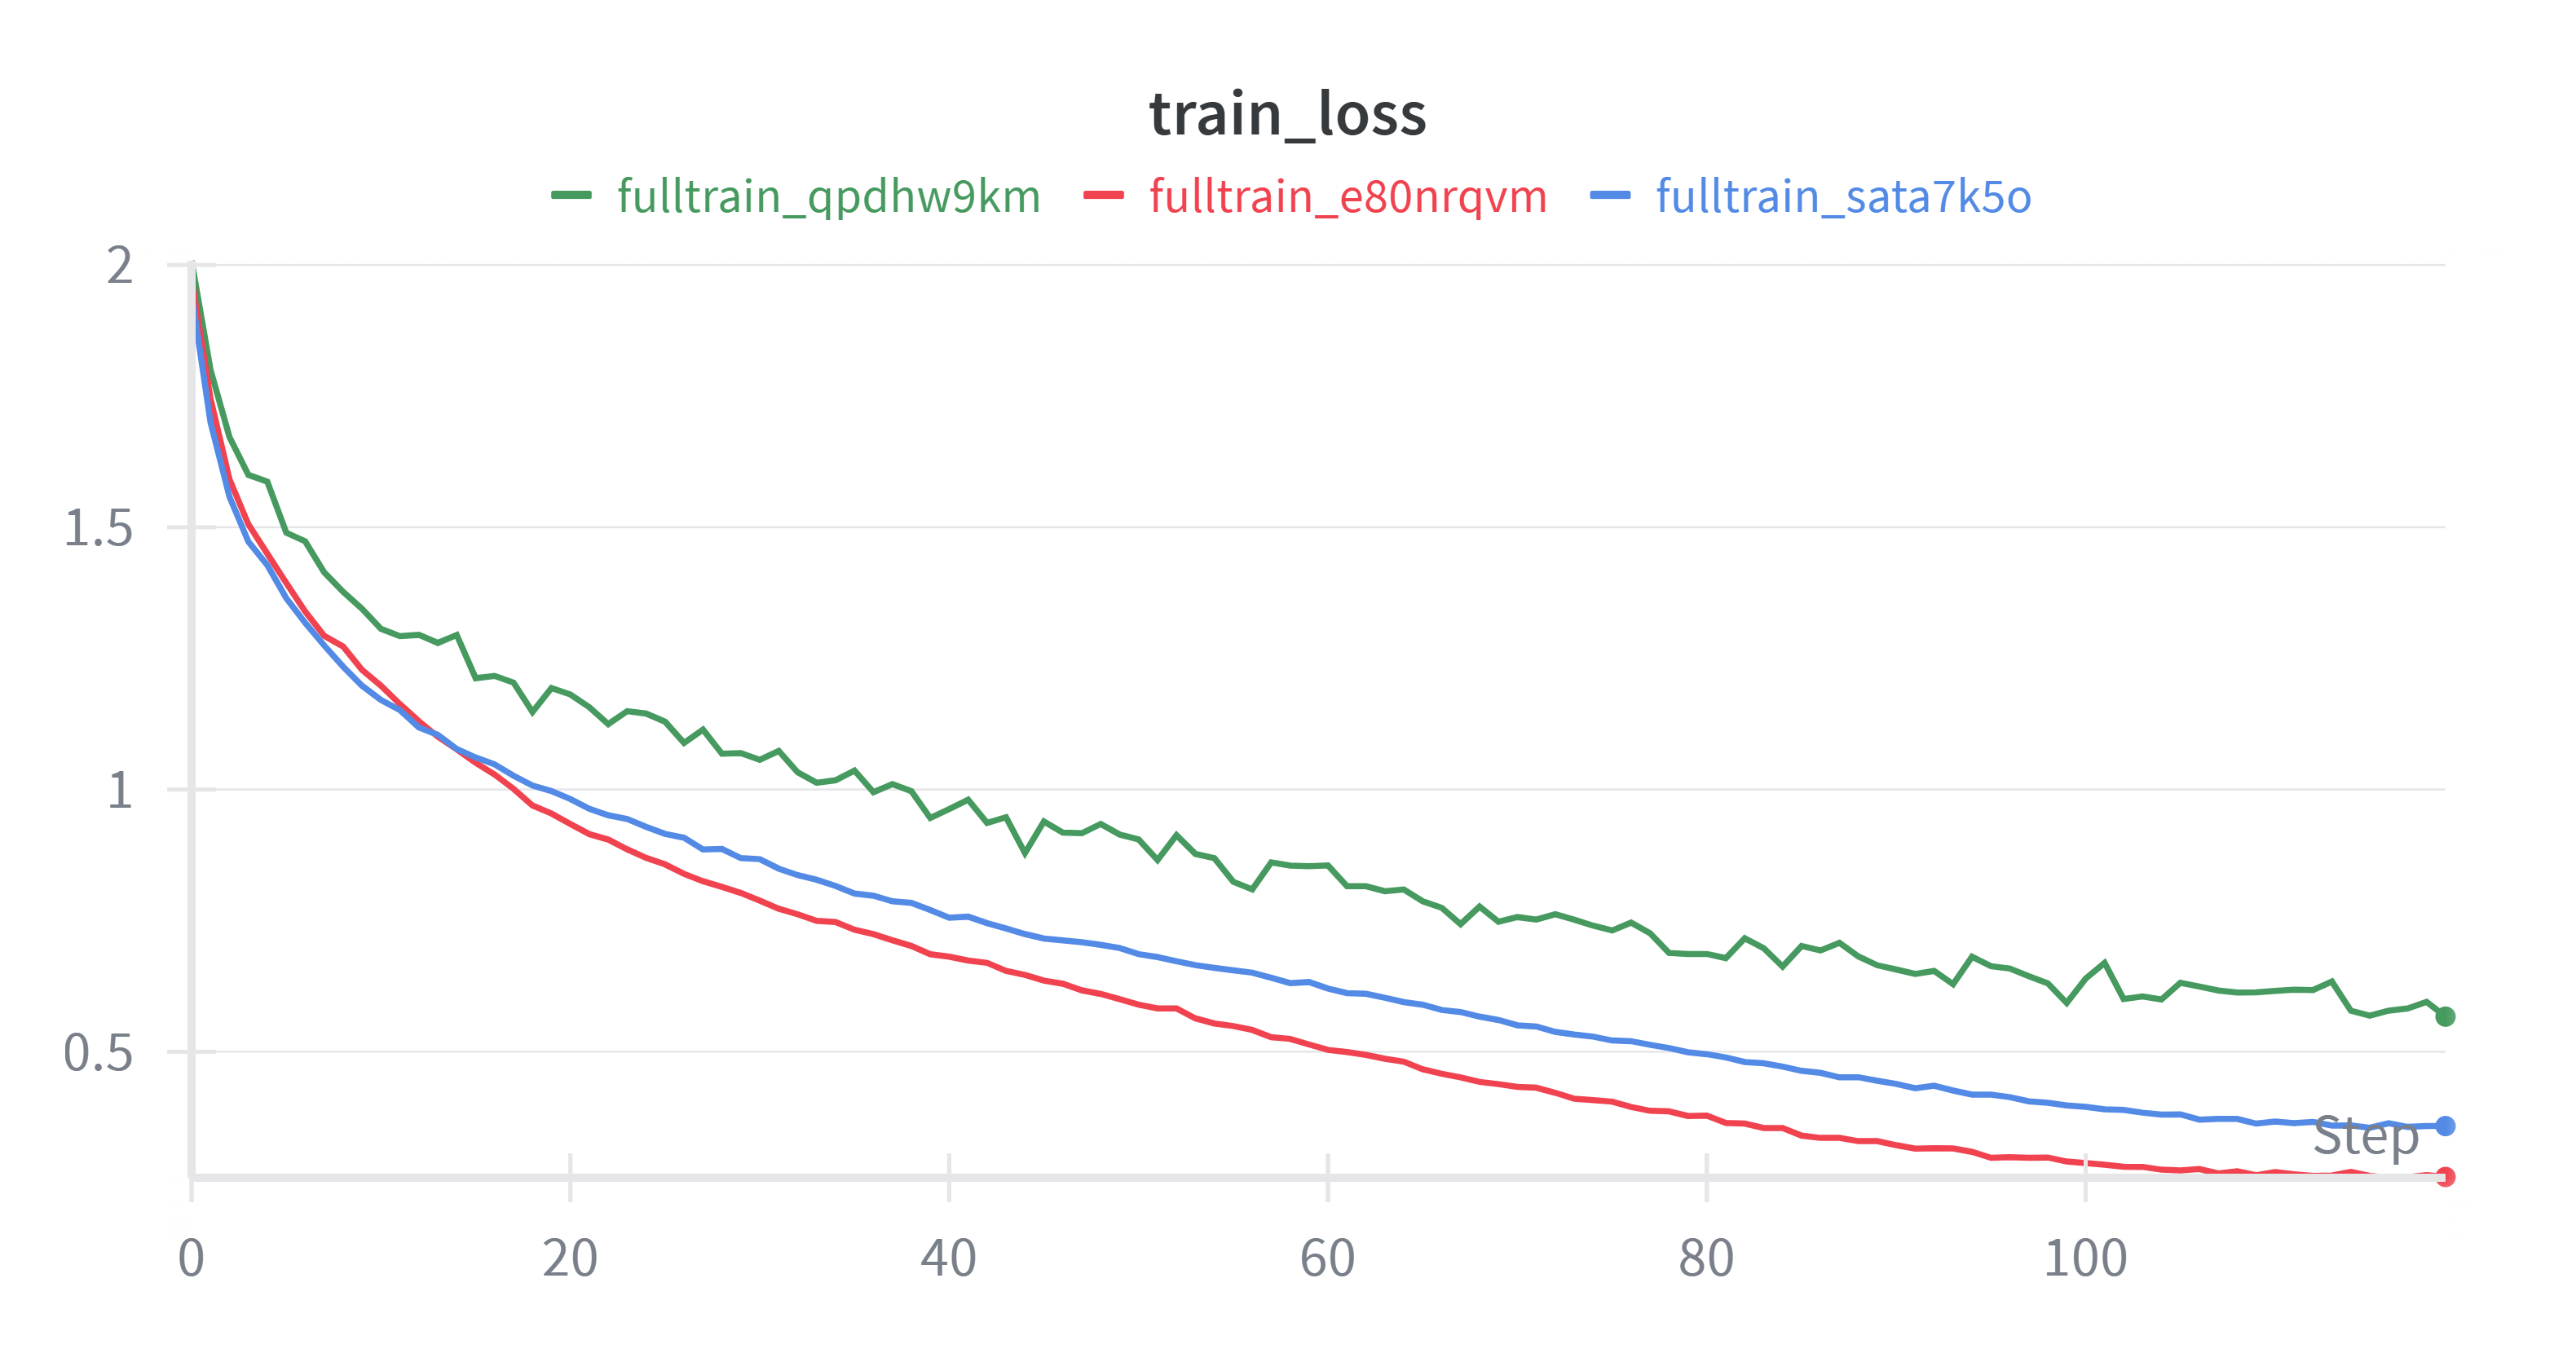

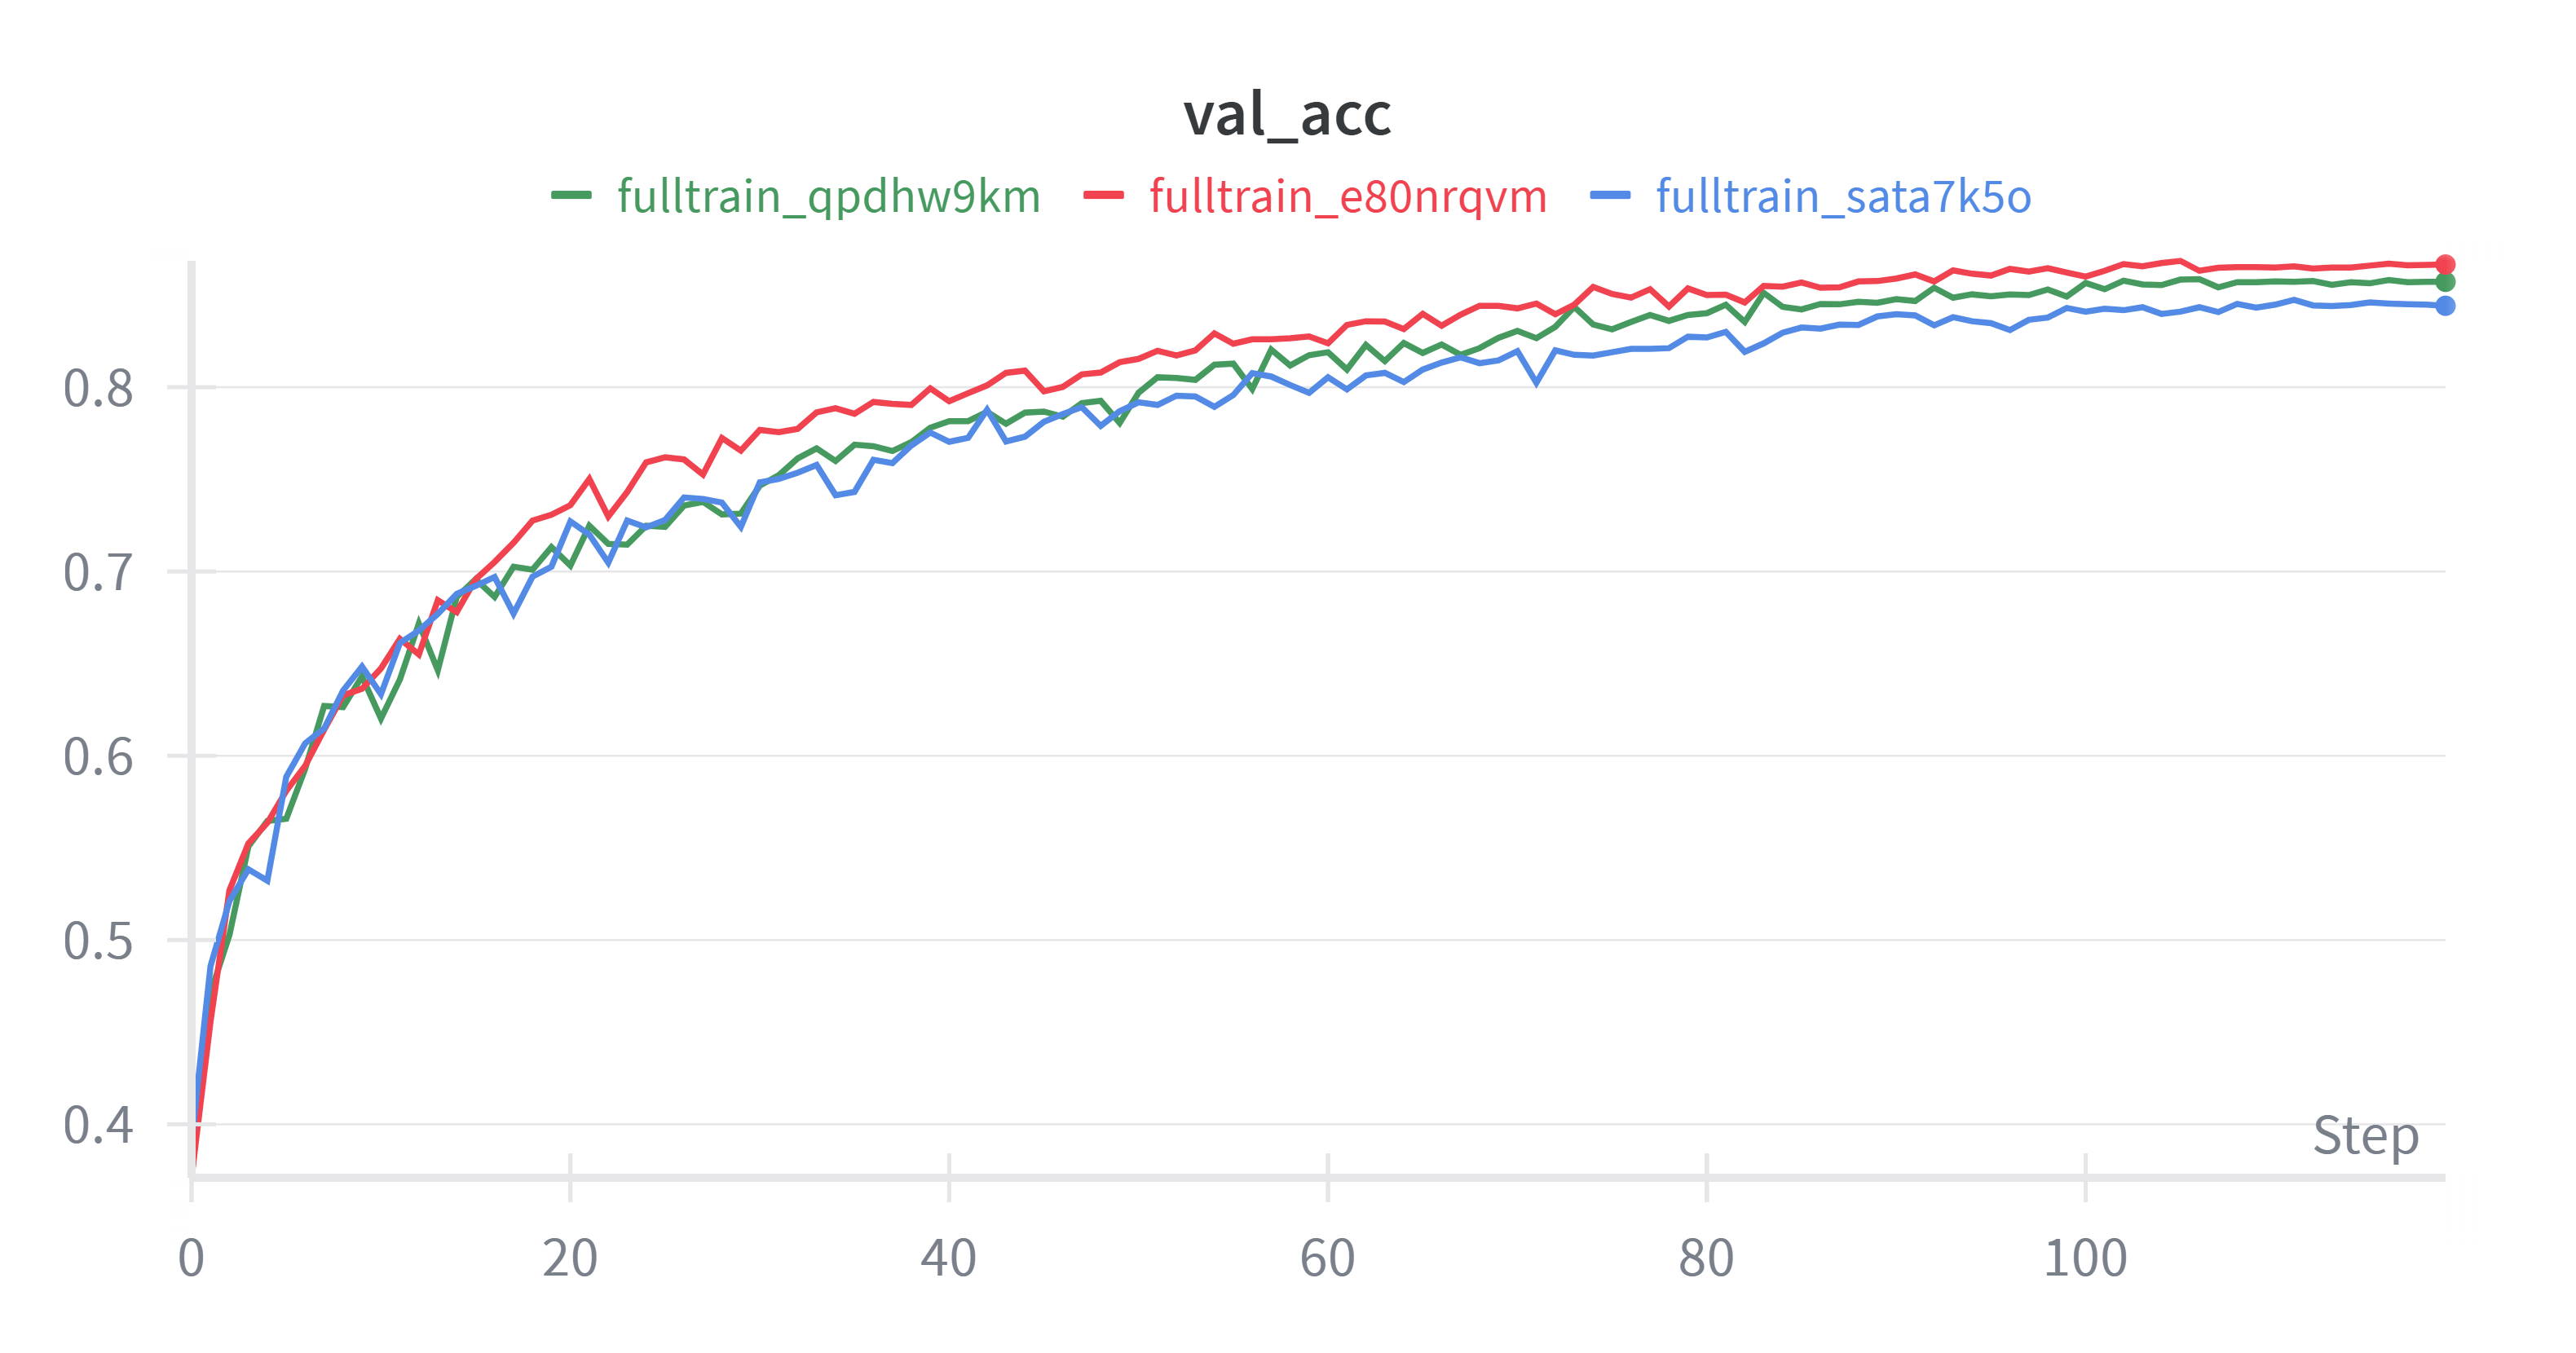

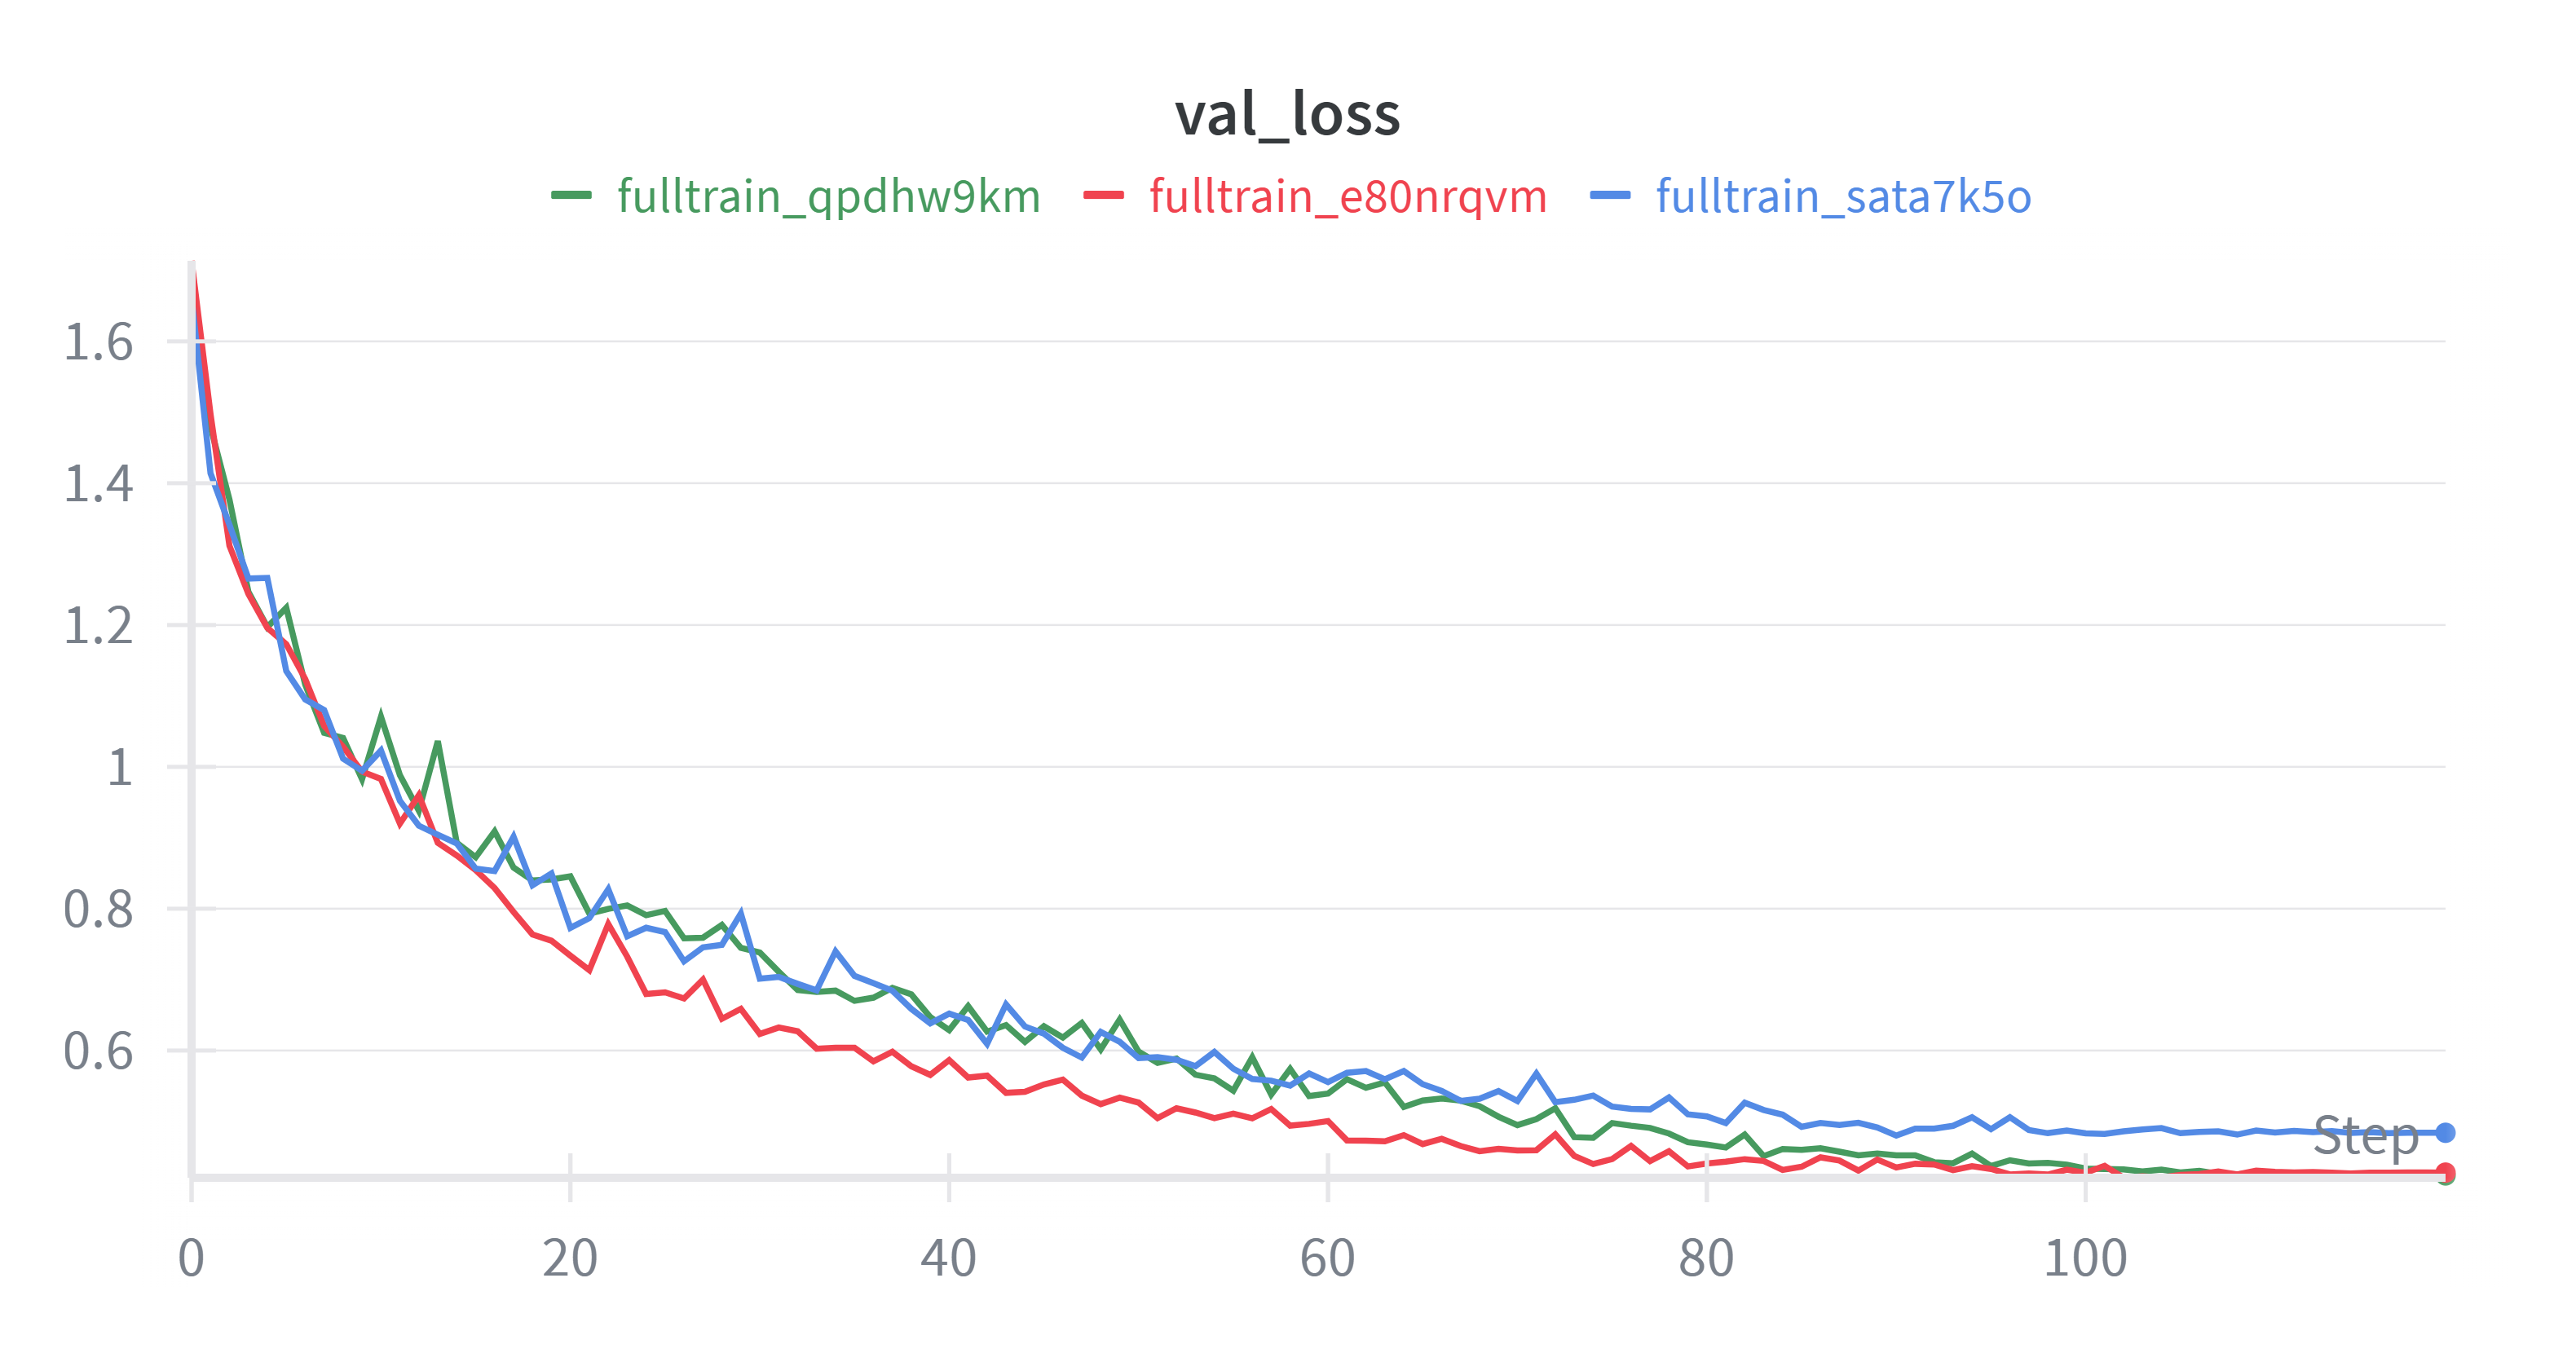

In [4]:
from IPython.display import Image, display

# Display images with reduced width (e.g., 400 pixels)
display(Image(filename='W&B Chart 10_5_2025, 1_35_51 AM.png', width=600))
display(Image(filename='W&B Chart 10_5_2025, 1_35_39 AM.png', width=600))
display(Image(filename='W&B Chart 10_5_2025, 1_35_31 AM.png', width=600))
display(Image(filename='W&B Chart 10_5_2025, 1_35_18 AM.png', width=600))
display(Image(filename='W&B Chart 10_5_2025, 1_35_02 AM.png', width=600))


# Config 2 achieved the highest validation and test accuracy.
### Best Validation Accuracy: **0.8686**
### Epochs trained: **119**
### Training Accuracy: **0.90762**
### Training Loss: **0.26129**
### Validation Accuracy: **0.8666**
### Validation Loss: **0.42783**
### Test Accuracy: **0.8722**
### **Note: Metrics were logged to Weights & Biases (W&B)**